# <font color=blue> Rotor temperature regression in R</font>

**Author:**  Armin Berger

Programming Language: R 3.6.1 (2019-07-05) in Jupyter Notebook

R Libraries used:
- glmnet 
- ggplot2
- tidyr
- lattice
- RColorBrewer
- viridisLite
- caret
- ggstance
- plotmo


The main purpose of the data set’s recording is to be able to model the rotor temperatures of a permanent magnet synchronous motor (PMSM) in real-time. Due to the intricate structure of an electric traction drive, direct measurement with thermal sensors is not possible for rotor temperatures, and even in case of the stator temperatures, sensor outage or even just deterioration can’t be administered properly without redundant modeling. In addition, precise thermal modeling gets more and more important with the rising relevance of functional safety.

The task is to design a model with appropriate feature engineering, that estimates one target temperature rotor temperature (“pm”) in a causal manner. In order to maintain real-time capability, model sizes should be as small as possible, while retain a high level of prediction accuracy, as temperature estimation in production will be deployed on best-cost hardware of traction drives in an automotive environment, where lean computation and lightweight implementation is key and crucial.

## Table of Contents

1. [Introduction](#sec_1)
3. [Exploratory Data Analysis](#sec_3)
3. [Methodology](#sec_4)
3. [Model Development](#sec_5)
3. [Results and discussion](#sec_6)
3. [Conclusion](#sec_7)
3. [References](#sec_8)

# <em> 1. Introduction <a class="anchor" id="sec_1"></a> <em>

The data set we using is called 'pmsm_temperature_data_A1_2021.csv' and has 15147 entries with the 13 features. For this project we will, however, only consider 9 features 
These features are:


* 'ambient': Ambient temperature as measured by a thermal sensor located closely to the stator.

* 'coolant': Coolant temperature. The motor is water cooled. Measurement is taken at outflow.

* 'u_d': Voltage d-component

* 'u_q': Voltage q-component

* 'motor_speed': Motor speed

* 'torque': Torque induced by current

* 'i_d': Current d-component

* 'i_q': Current q-component

* 'profile_id': group of observation

* 'pm': Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared thermography unit.

Install and load all required libraries

In [1]:
## install packages

#install.packages('viridis')
#install.packages("tidyverse")
#install.packages('dplyr')
#install.packages("caret")
#install.packages("ggstance")
#install.packages("plotmo")

In [2]:
## load packages

library(glmnet)         # used for shrinkage models
library(ggplot2)        # used for visulisation
library(tidyr)          # used for editing of dataframes
library(lattice)        # used for visulisation
library(RColorBrewer)   # used for color schems
library(viridisLite)    # used for color schems
library(caret)          # used for model training
library(ggstance)       # used for visulisation
library(plotmo)         # used for visulisation of model output

Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-16



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘ggstance’


The following objects are masked from ‘package:ggplot2’:

    GeomErrorbarh, geom_errorbarh


Loading required package: Formula

Loading required package: plotrix

Loading required package: TeachingDemos



To model our data we need to first understand it. This is done using Exploratory Data Analysis or short EDA. We can skip the usual wrangling process since the data has already be wrangeling for us and is ready to be used for EDA.

Firstly, we will read in the data which is saved in a csv format.

In [3]:
# first read in data saved in csv format
rotor_input = read.csv('pmsm_temperature_data_A1_2021.csv')

In [4]:
# quick overview of the data
head(rotor_input)

ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0.1176819,-1.040829,-1.0267303,0.9250645,1.2124813,0.3586899,-0.8343090,0.3229330,-0.08831267,-0.7353304,-0.4340061,-0.2742660,4
-0.5547717,-1.087189,-1.2258921,0.5125759,2.0241232,0.2841797,-1.3638294,0.2340145,0.71040170,-0.4083708,0.1866731,0.5596492,4
-0.7722329,-1.063652,0.2988575,0.9562448,-0.1402458,-0.2591392,1.0291220,-0.2457111,-1.59260400,-1.5299687,-1.6798143,-1.7312210,4
0.2199584,-1.083475,-1.0261079,0.9278145,1.2124836,0.3574240,-0.8381095,0.3228101,-0.14167030,-0.8073816,-0.5005400,-0.3471646,4
0.4015749,-1.078981,0.3155328,-0.7094008,-0.9518901,-0.2562895,1.0291730,-0.2457109,-1.96488810,-1.7469838,-1.9857602,-1.9713503,4
-0.7697667,-1.089577,0.2999456,0.9589649,-0.1402460,-0.2592790,1.0291333,-0.2457186,-1.77564350,-1.5568651,-1.6943698,-1.7499026,4


For this task we only want the first 9 and the last feature of the of the data set.

In [5]:
# subselect only the data we need
rotor_data <- rotor_input[-c(10:12)]

In [6]:
# get the name of all features of the data set
names(rotor_data)

[1] "ambient"     "coolant"     "u_d"         "u_q"         "motor_speed"
 [6] "torque"      "i_d"         "i_q"         "pm"          "profile_id"

In [7]:
# check the new dimensions of our data set
dim(rotor_data)

[1] 15147    10

After reading in the data and removing not used columns in our data set we can exainbe the data type, distrubution and spread of each feature. 

In [8]:
# get an overview over the varible types
str(rotor_data)

'data.frame':	15147 obs. of  10 variables:
 $ ambient    : num  0.118 -0.555 -0.772 0.22 0.402 ...
 $ coolant    : num  -1.04 -1.09 -1.06 -1.08 -1.08 ...
 $ u_d        : num  -1.027 -1.226 0.299 -1.026 0.316 ...
 $ u_q        : num  0.925 0.513 0.956 0.928 -0.709 ...
 $ motor_speed: num  1.212 2.024 -0.14 1.212 -0.952 ...
 $ torque     : num  0.359 0.284 -0.259 0.357 -0.256 ...
 $ i_d        : num  -0.834 -1.364 1.029 -0.838 1.029 ...
 $ i_q        : num  0.323 0.234 -0.246 0.323 -0.246 ...
 $ pm         : num  -0.0883 0.7104 -1.5926 -0.1417 -1.9649 ...
 $ profile_id : int  4 4 4 4 4 4 4 4 4 4 ...


We have 8 predictor variables of which all numeric. The target pm is numeric as well.

In [9]:
# basic overiew of the spread of the data
summary(rotor_data)

    ambient           coolant              u_d               u_q         
 Min.   :-3.3278   Min.   :-1.23704   Min.   :-1.6537   Min.   :-1.8146  
 1st Qu.:-0.5390   1st Qu.:-0.69087   1st Qu.:-0.4860   1st Qu.:-1.2683  
 Median :-0.1403   Median :-0.04497   Median : 0.3001   Median :-0.3806  
 Mean   :-0.1074   Mean   : 0.18125   Mean   : 0.1102   Mean   :-0.1910  
 3rd Qu.: 0.4981   3rd Qu.: 1.00946   3rd Qu.: 0.3503   3rd Qu.: 0.7410  
 Max.   : 2.7106   Max.   : 2.29464   Max.   : 2.2735   Max.   : 1.7702  
  motor_speed          torque              i_d               i_q          
 Min.   :-1.2224   Min.   :-3.31634   Min.   :-3.1764   Min.   :-3.30867  
 1st Qu.:-1.2224   1st Qu.:-0.25765   1st Qu.:-0.5524   1st Qu.:-0.24579  
 Median :-0.4318   Median :-0.25564   Median : 0.5874   Median :-0.24571  
 Mean   :-0.1913   Mean   :-0.08396   Mean   : 0.1775   Mean   :-0.08147  
 3rd Qu.: 0.6743   3rd Qu.: 0.35654   3rd Qu.: 1.0291   3rd Qu.: 0.34990  
 Max.   : 2.0241   Max.   : 3.01

All features except for profil_id appear to be transformed to a z-score normal distribution. Moreover, ther appear to be no noticable outlier values.

#### <span style="color:blue"> Figure A1 - Boxplots of all features </span>

#### Aim: 
Check the dirstribution of all varaibles using boxplots. Boxplots seperate the data into quartiles and enable us to observe any skews in the data and potential outliers.

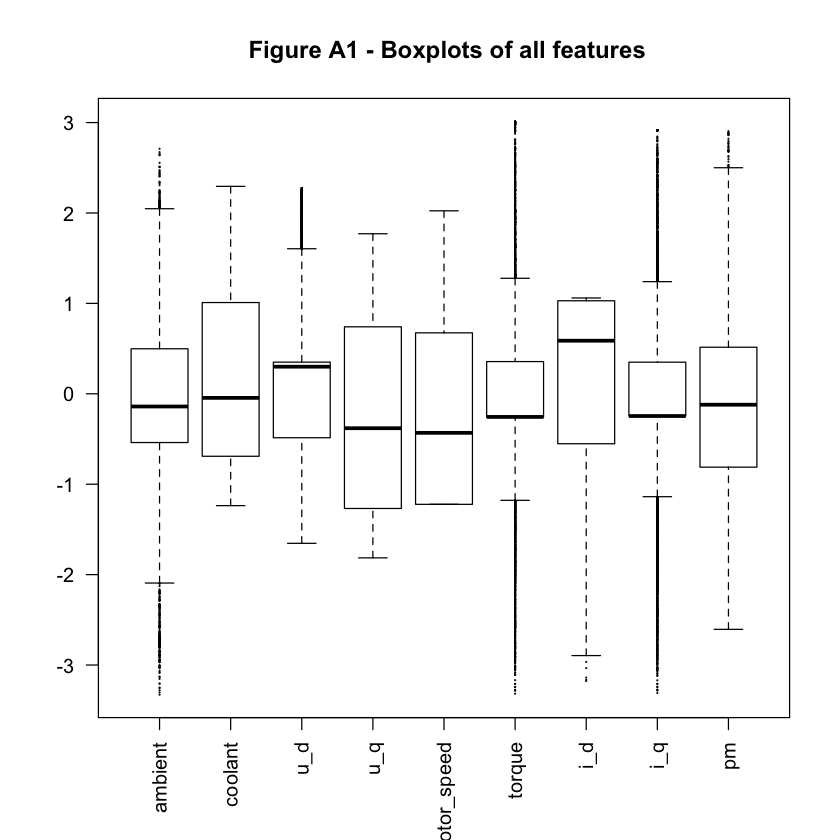

In [10]:
## FIGURE A1 ##

# boxplot of all features
boxplot(rotor_data[1:9], las=2, cex = 0.1,  main = ' Figure A1 - Boxplots of all features')

####  Analysis:
The boxplots show that all predictors we transformed to a z-score normal distribution. This enables for easier comparison between predictors as well as as model building since they are all on the same scale.

One of the main observations is that most varaibles do not appear to be normally deistrbuted. Moreover, some variables such as 'ambient', 'torque', and 'i_q' have a lot of potential outliers, while variables such as 'coolant', 'u_d', 'u_q', 'motor_speed', and 'i_d' have no visible potential outliers.

#### <span style="color:blue"> Figure A2 - Violin Plots of all features </span>
####  Aim: 

We use violin plots to depict the distributions of all varaibles using density curves. Violin plots are more 'flexible' than boxplots since they let you see variations in the data which is particullarly useful for multimodal distributions.

Warning message:
“position_dodge requires non-overlapping x intervals”


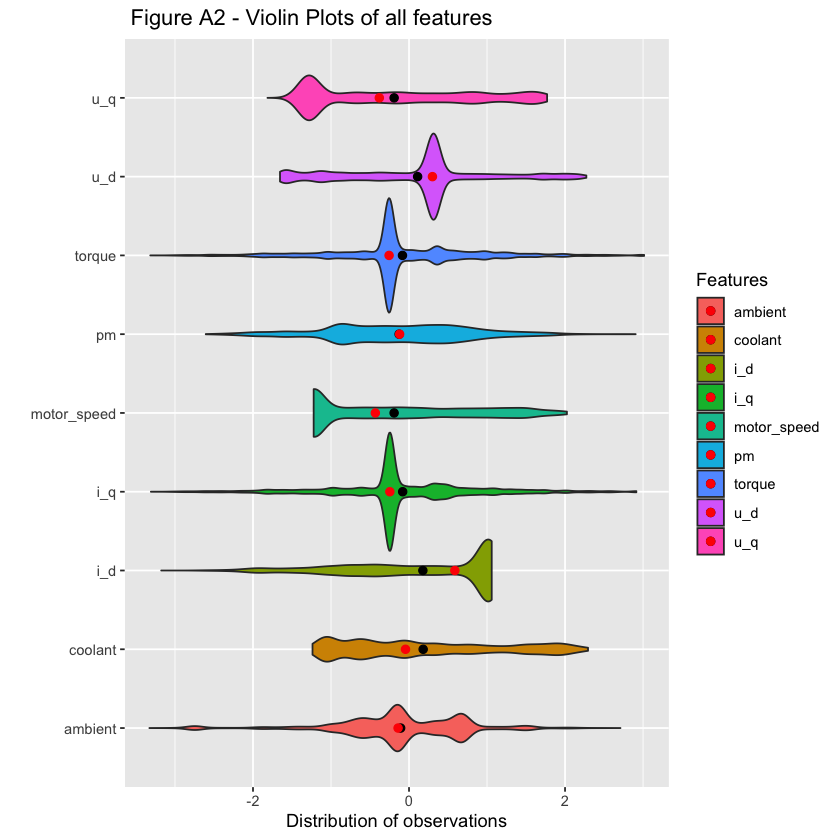

In [11]:
## FIGURE A2 ##

# transform the rotor_data from a 'wide' format to a tidy format
tidy_rotor <- rotor_data[1:9] %>% gather(key = 'Features', value = 'values')

# plot the violin plot
ggplot(tidy_rotor, aes(x = Features, y = values, fill = Features)) +
geom_violin(width = 1.5, size = 0.5) +
coord_flip() +   # flip the violin plot horizontally
xlab('') +
labs(title=' Figure A2 - Violin Plots of all features')+
ylab("Distribution of observations") +
stat_summary(fun = mean, geom = 'point',  size = 2)+
stat_summary(fun = median, geom = 'point', size = 2, col = 'red')
   

####  Analysis: 

The violin plots show that many features such as motor_speed and i_d have extremely skewed distributions. This can be observed by both the density curve of each distribution as well as the the difference between mean (black) and median (red). We will attempt to normalize the distributions of these features using various transformations to offset skews in the data.

#### <span style="color:blue"> Figure A3 - Histograms of all features </span>
####  Aim: 
Use histograms to understand the distribution of each variable further. In order to get a more granular view of the distribution we chose to display the data in 15 buckets. To underline how each feature's distribution deviates from the normal distribution we have add the theoretical normal distribution and the actaul distribution density curve.

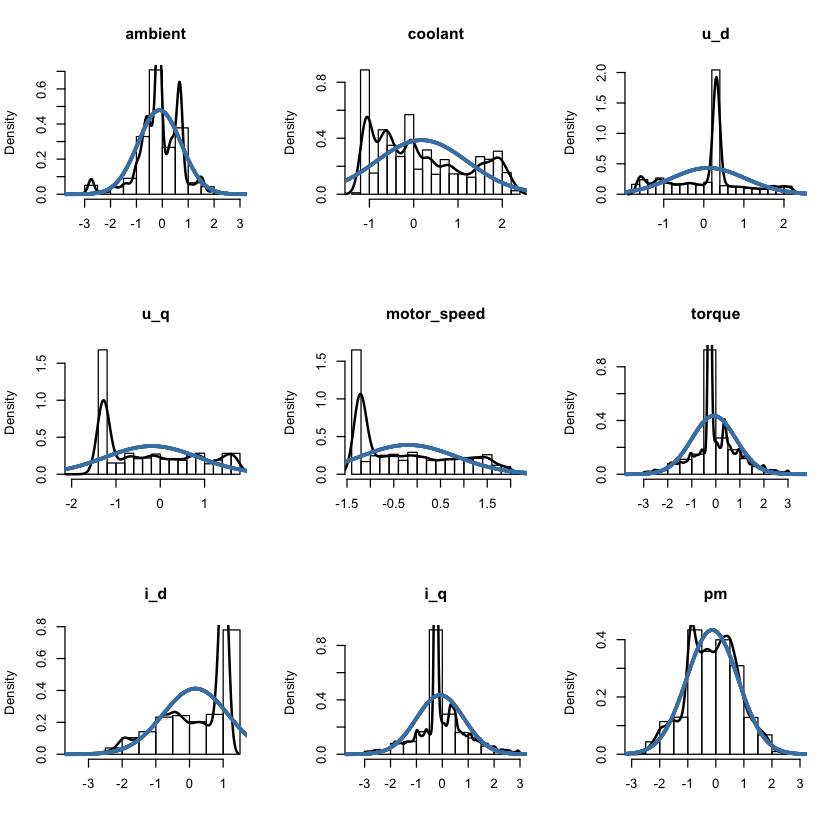

In [12]:
## FIGURE A3 ##

# create a grid for our plots 
par(mfrow=c(3,3))

# plot all columns of our data set as histograms
# add a black line for the distribution density curve
# add a blue line for the theoretical normal distribution given each features mean and standard deviation
for(i in 1:9) {
    
    # plot histogram
    hist(rotor_data[,i], main = names(rotor_data)[i], breaks = 15,prob = T, , xlab = '')
    
    # save mean and sd of each variable 
    # as well as parameters and distribution of a normal distribution
    var_sd <- sd(rotor_data[,i])
    var_mean <- mean(rotor_data[,i])
    normal_seq <- seq(from = -4, to = 4, by = 0.0001)
    normal_dis <- dnorm(normal_seq, var_mean, var_sd)
    
    # plot varaible distribution curve
    lines(density(rotor_data[,i]), col = "black", lwd = 2)
    
    # plot theoretical normal distribution of each features
    lines(normal_seq, normal_dis, col = "steelblue", lwd = 3)

}


####  Analysis: 
The four main features that should be considered when analysing histograms are: shape, center, spread, and outliers. 

Shape: \
The histograms of all features showed that a lot of the data is asymmetricaly distributed.
Features such as 'u_d' , 'u_q' , 'motor_speed', 'torque' , 'i_d' and 'i_q' have oberservations
clustering around a few values while the rest of the data is widely disperesed. This phenomena is reffered to as high a kurtosis distribution. The only variable that seems to be roughly normaly distributed is the taget 'pm'.

Center: \
The features 'ambient' , 'u_d' , 'torque' , 'i_q' and 'pm' are centered around the middle.

The features 'coolant' , 'u_q' , and 'motor_speed' are severly right skewed.

The features 'i_d' is severly left skewed.

Spread: \
In terms of data spread a lot of the feature's data is very spread out, meaning they have large distribution tails. This is refered to as high kurtosis data, meaning that the vast majority of observations cluster around a singular point. Only the feature 'ambient', and 'pm' appears to have less spread.

Outliers: \
Based on the histogram plots it is hard to reliably identify potential outliers. Despite many features having large tails there are  no 'isolated' observations.

#### <span style="color:blue"> Figure A4 - QQ-Plots of all features </span>
####  Aim: 
A further useful plotting tool to analyse the data distribution of a variable is a Quantile-Quantile Plot / QQ-Plot. 

We plot a set of quantiles from the normal distribution against a set of quantiles from the distribution of each of the data's features. This enables us to visually check if a set of data from one of our features possibly came from a normal distribution.

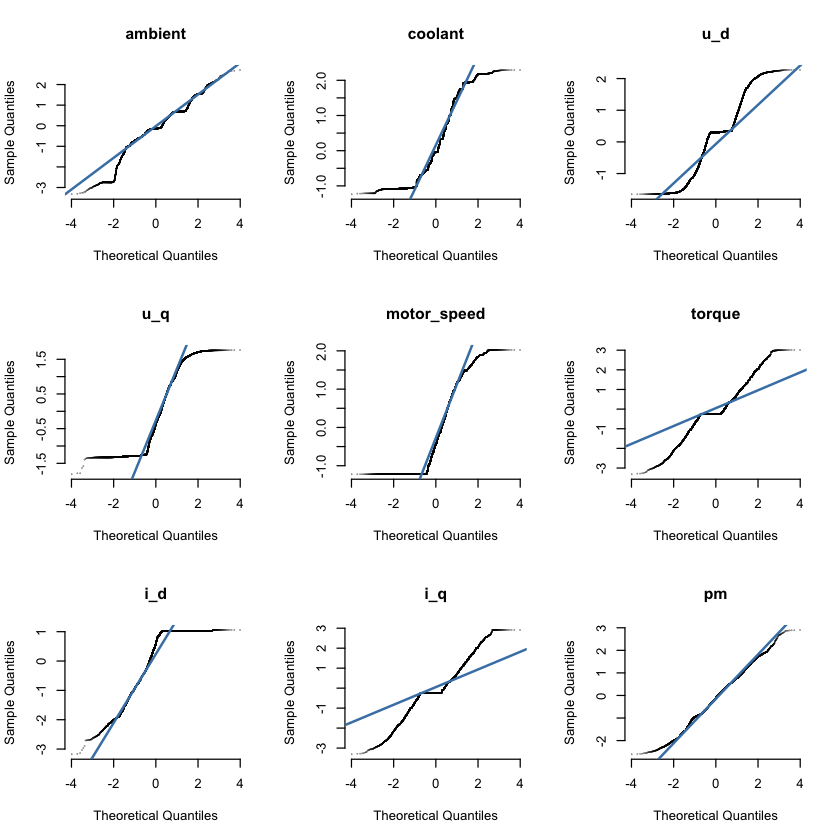

In [13]:
## FIGURE A4 ##

# create a grid for our plots 
par(mfrow=c(3,3))

# plot all columns as histograms 
for(i in 1:9) {
    qqnorm(rotor_data[,i], pch = 1, cex = 0.05, frame = FALSE, main = names(rotor_data)[i])
    qqline(rotor_data[,i], col = "steelblue", lwd = 2)
}


####  Analysis: 
When analysing QQ-Plots the main thing we need to observe is how close the distribution of our variables (black line) mirrors the supposed normal distribution (blue line).

Using this visual aid we can see that only 'pm' and 'ambient' are very roughly normally distributed, with  'ambient' having a light left skew.

The features 'coolant' , 'u_d' , 'u_q' , 'motor_speed' , 'torque' , 'i_d' , and 'i_q' are all non-normally distributed. This reaffirms the the observations made in Figure A2. 

### <span style="color:red"> Distribution take away: </span>

Except for 'pm' and 'ambient' non of the features are normally distributed. This will make it harder to fit an understandable and low complexity model to the data since a lot of less complex machine learning algorithms such as least squares regression require the normality of both predictors and target variables in order to perform well.

#### <span style="color:blue"> Figure A5 - Pair plots of all features  </span>
####  Aim: 

The pair splot creates scatter plots of each of the nine features. Thus we overall get 81 scatter plots. These plots enable us to observe bivariate relationships between features.

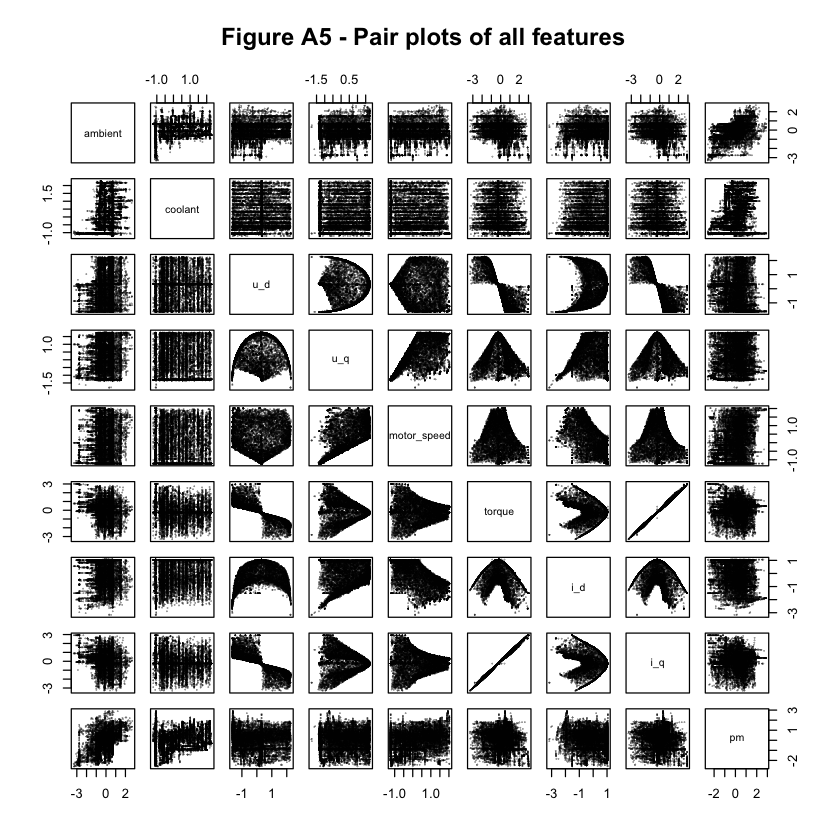

In [14]:
## FIGURE A5 ##

pairs(rotor_data[1:9], cex = 0.05, main = ' Figure A5 - Pair plots of all features' )

#### Analysis: 

Based on the pair plot it becomes apparent that some predictor variables are correlated to one another. For reference, there is a strong positive linear relationship between 'torque' and 'i_q' as well as a positive linear relationship between 'motor_speed' and 'u_q'. The relationship between 'torque' and 'i_q' is expectable since 'i_q' measures electric current and thus an increase in electric current should lead to an increase in engine torque. Similarly, the linear relationship between 'motor_speed' and 'u_q' is expectable since an increase in voltage should lead to an increase in motor speed. Since a lot of predictors appears to be strongly or perfectly correlated to one another we will have to exclude some in our model building process to avoid collinearity. 

To understand the bivariate relationships between each predictor and the target 'pm' we will plot them individually in the next step.

#### <span style="color:blue"> Figure A6 - Scatter plot of 'pm' and all other predictors  </span>
####  Aim: 

Plot each variable against the target 'pm'. This aims to show which features have a  strong effect on the rotor temperature.

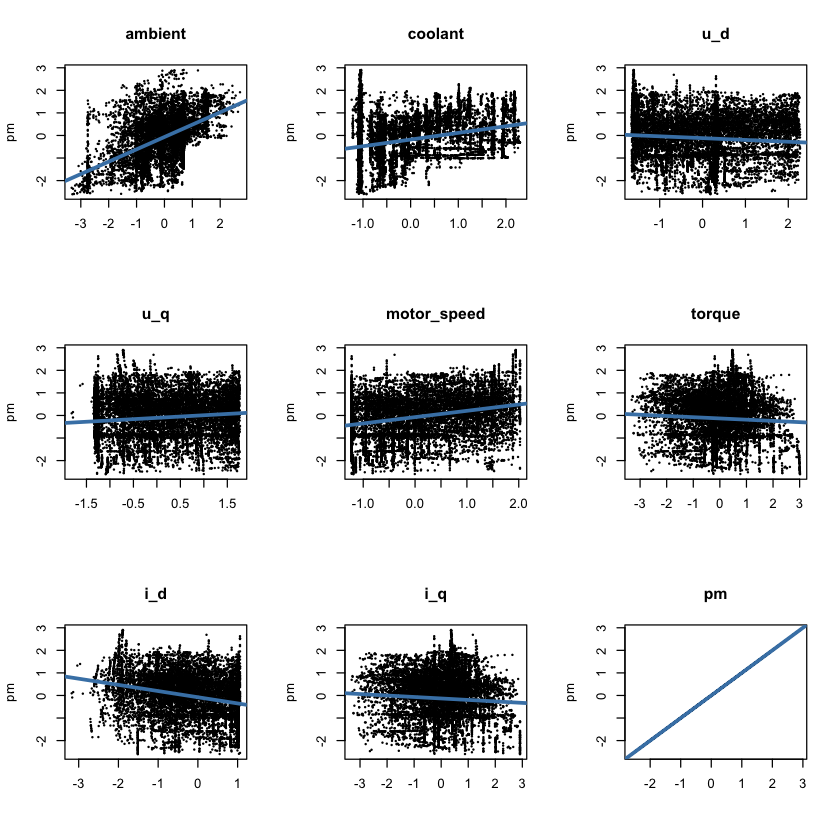

In [15]:
## FIGURE A6 ##

# this helps us understand the relationship between each predictor and the target
par(mfrow=c(3,3))

attach(rotor_data)

# plot each varaible as a scatter plot
for(i in 1:9) {
    
    plot(x = rotor_data[,i], y = pm, main = names(rotor_data)[i], cex = 0.2, ylab = 'pm', xlab = '')
    abline(lm(rotor_data$pm ~ rotor_data[,i]), lwd = 3, col = 'steelblue')
    
}


####  Analysis: 

After assessing the linear trendlines fitted to each scatter plot, only the predictor 'ambient' apears to have a clear positive linear relationship to 'pm'. The features 'u_d', 'u_q', 'torque', and 'i_q' appear to have no linear relationship with the target 'pm'. In the model building process we would, thus, ensure to include 'ambient' as a predictor.

#### <span style="color:blue"> Figure A7 - Correlation Plot of all features </span>
####  Aim: 
The correlation plot displays the correlation between all features. This will eanbles us to identify features with high collinearity which should be excluded from models built on least squares estimates, as well as identify features associated with the target.

In [16]:
## Build a display panel to show correlations

# code reused from tutorial week 3
my_panel <- function(x, y, z, ...) {
    
    panel.levelplot(x, y, z,...)
    
    panel.text(x, y, round(z, 1))
    
}

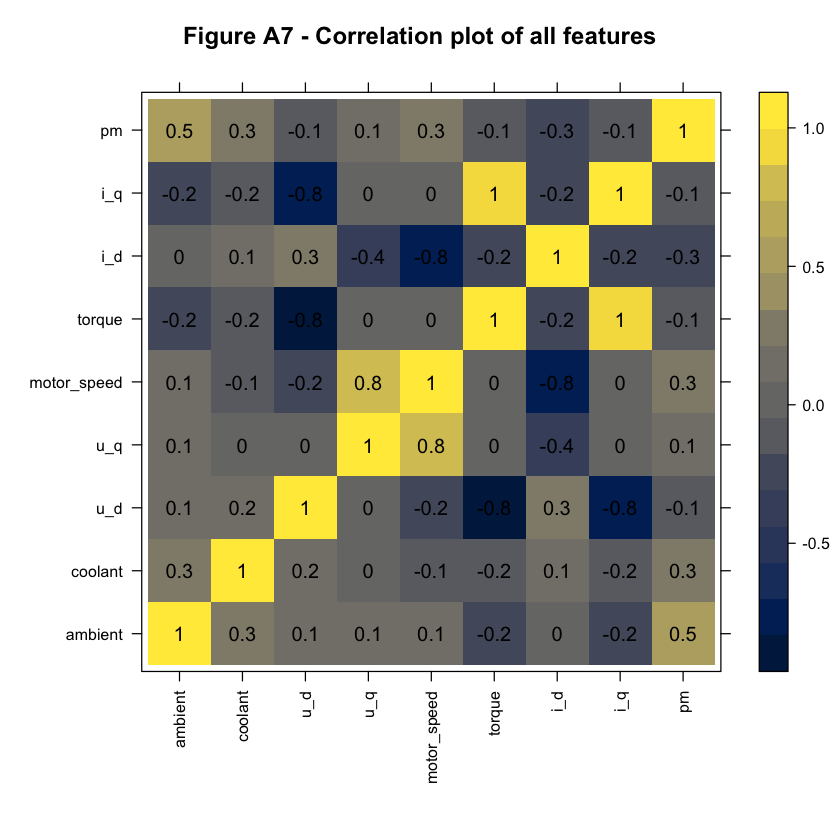

In [17]:
## FIGURE A7 ##

levelplot(cor(rotor_data[1:9]), scales = list(x = list(rot = 90)),
          main = 'Figure A7 - Correlation plot of all features', xlab = '', ylab = '',
          panel = my_panel, col.regions = cividis(20))

####  Analysis: 
The correlation plot shows that only 'ambient' has a signifacnt positive correlation to 'pm' of 0.5. The features 'coolant' and 'motor_speed' have a weak postive correlation to 'pm' of 0.3, while the feature 'i_d' has a weak negative correlation to 'pm' of -0.3. Overall, given the small number of features that have a significant linear relationship to the target 'pm' it will be hard to build an understandable and low complexity model with accurate predictions. 

A further problem is that multiple predictors are highly correlated to another, such as 'i_q' to 'u_d', 'torque' to 'u_d', 'i_q' to 'torque', etc. . This means we will likely have to exclude fome features in our model buidling process for all models built on least squares estimates to adjust for such multicollinearity. An easy way to identify and remove such correlated factors is the findCorrelation() function. We will determine all predictors affected by collinearity that have a Pearson correlation of more than 0.8 to another. Then we will exclude some of them in models built on least squares estimates.

In [18]:
# check for correlation between features
cor_matrix <- cor(rotor_data[1:9])
cor_matrix

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
ambient,1.00000000,0.29806168,0.14522783,0.090443197,0.09340354,-0.216923004,-0.02150512,-0.215261583,0.49579285
coolant,0.29806168,1.00000000,0.15828490,-0.040009453,-0.06987018,-0.161075562,0.13280955,-0.157714976,0.33273139
u_d,0.14522783,0.15828490,1.00000000,-0.044241460,-0.18795159,-0.834602742,0.31702641,-0.811286005,-0.08094098
u_q,0.09044320,-0.04000945,-0.04424146,1.000000000,0.79804238,-0.005299271,-0.36225876,0.001397243,0.13218314
motor_speed,0.09340354,-0.06987018,-0.18795159,0.798042376,1.00000000,0.033811433,-0.77070022,0.019383595,0.31228750
torque,-0.21692300,-0.16107556,-0.83460274,-0.005299271,0.03381143,1.000000000,-0.22851851,0.996858218,-0.05482106
i_d,-0.02150512,0.13280955,0.31702641,-0.362258758,-0.77070022,-0.228518506,1.00000000,-0.200093149,-0.28855700
i_q,-0.21526158,-0.15771498,-0.81128600,0.001397243,0.01938359,0.996858218,-0.20009315,1.000000000,-0.06523648
pm,0.49579285,0.33273139,-0.08094098,0.132183137,0.31228750,-0.054821059,-0.28855700,-0.065236479,1.00000000


In [19]:
# locate correlated predictors with a correlation to another above 0.8
findCorrelation(cor_matrix, cutoff = 0.80, verbose = TRUE)

Compare row 3  and column  6 with corr  0.835 
  Means:  0.322 vs 0.247 so flagging column 3 
Compare row 6  and column  8 with corr  0.997 
  Means:  0.242 vs 0.235 so flagging column 6 
All correlations <= 0.8 


[1] 3 6

The predictors most strongly affected by multicollinearity are :

* u_d and torque
* torque and i_q
* u_d and i_q 

Since, the features 'u_d' and 'torque' only have a correlation of -0.08 and -0.05 to the target 'pm' we will exclude them in models built on least squares estimates and use 'i_q' which has little to no collinearity to other predictors.

In [20]:
# change order of columns to make exclusion of features easier
rotor_data <- rotor_data[, c(3,6,1,2,4,5,7,8,9,10)]

In [21]:
# print head of rotor_data
head(rotor_data)

u_d,torque,ambient,coolant,u_q,motor_speed,i_d,i_q,pm,profile_id
-1.0267303,0.3586899,0.1176819,-1.040829,0.9250645,1.2124813,-0.8343090,0.3229330,-0.08831267,4
-1.2258921,0.2841797,-0.5547717,-1.087189,0.5125759,2.0241232,-1.3638294,0.2340145,0.71040170,4
0.2988575,-0.2591392,-0.7722329,-1.063652,0.9562448,-0.1402458,1.0291220,-0.2457111,-1.59260400,4
-1.0261079,0.3574240,0.2199584,-1.083475,0.9278145,1.2124836,-0.8381095,0.3228101,-0.14167030,4
0.3155328,-0.2562895,0.4015749,-1.078981,-0.7094008,-0.9518901,1.0291730,-0.2457109,-1.96488810,4
0.2999456,-0.2592790,-0.7697667,-1.089577,0.9589649,-0.1402460,1.0291333,-0.2457186,-1.77564350,4


# <em> 3. Methodology<a class="anchor" id="sec_4"></a> <em>

In this project three different models will be deployed to predict the target 'pm'. Since we have a target variable and our target 'pm' is continuous we will deploy regression models for our prediction task. Moreover, since this task is focused on analysing the data and models deployed, we will focus on models which are understandable and low in complexity.

The four parametric models used are:

* multilinear regression

* polynomial regression 

* ridge regression

* lasso regression

Since the first two models assume that all features are roughly normally distributed we will use different transformation techniques in an attempt to mitigate the left- and right skews observed during EDA. Due to the high level of kurtosis in many features distribution achieving a normal distribution will be exceptionally difficult.

# <em> 4. Model Development <a class="anchor" id="sec_5"></a> <em>

## 4.0 Data Transformnation

Data transformation helps us to turn heavily skewed or high kurtosis data into a distribution that is closer to the normal distribution. For right-skewed data, we have applied log or root transformations and for left-skewed data, exponential transformations have been applied. The main challenge was dealing with high kurtosis features.
A lengthy trial and error combination of transformations was not able to create distributions that are closer to the normal distribution so a lot of features have very long distribution tails.

Overall, we expect transformations to enable us to build models with more accurate predictions.

Apply common transformations in an attempt to remove left- or right skews from the distribution of data.

* square transformation     -> left skewed data 
* natural log transformation -> right skewed data 
* cube root transformation   -> right skewed data 

In [22]:
# transformed data
data_transform <- rotor_data

# save lenght of data frame being transformed
len <- length(data_transform[1:8])

# save names of columns
col_names <- colnames(data_transform[,1:len])

col_names 

[1] "u_d"         "torque"      "ambient"     "coolant"     "u_q"        
[6] "motor_speed" "i_d"         "i_q"

##### I. Square Transformation

In [23]:
# transform all features using the square transformation 'x^2'
for(i in 1:len) {
    
    df_name <- paste(col_names[i],'_sq')
    
    data_transform[df_name] <- data_transform[,i]^2
    
}

In [24]:
head(data_transform)

u_d,torque,ambient,coolant,u_q,motor_speed,i_d,i_q,pm,profile_id,u_d _sq,torque _sq,ambient _sq,coolant _sq,u_q _sq,motor_speed _sq,i_d _sq,i_q _sq
-1.0267303,0.3586899,0.1176819,-1.040829,0.9250645,1.2124813,-0.8343090,0.3229330,-0.08831267,4,1.05417511,0.12865847,0.01384903,1.083325,0.8557443,1.47011090,0.6960716,0.10428575
-1.2258921,0.2841797,-0.5547717,-1.087189,0.5125759,2.0241232,-1.3638294,0.2340145,0.71040170,4,1.50281144,0.08075810,0.30777159,1.181981,0.2627341,4.09707473,1.8600306,0.05476279
0.2988575,-0.2591392,-0.7722329,-1.063652,0.9562448,-0.1402458,1.0291220,-0.2457111,-1.59260400,4,0.08931583,0.06715312,0.59634365,1.131356,0.9144041,0.01966888,1.0590921,0.06037393
-1.0261079,0.3574240,0.2199584,-1.083475,0.9278145,1.2124836,-0.8381095,0.3228101,-0.14167030,4,1.05289742,0.12775189,0.04838171,1.173918,0.8608397,1.47011648,0.7024276,0.10420636
0.3155328,-0.2562895,0.4015749,-1.078981,-0.7094008,-0.9518901,1.0291730,-0.2457109,-1.96488810,4,0.09956095,0.06568430,0.16126243,1.164201,0.5032495,0.90609476,1.0591971,0.06037382
0.2999456,-0.2592790,-0.7697667,-1.089577,0.9589649,-0.1402460,1.0291333,-0.2457186,-1.77564350,4,0.08996737,0.06722562,0.59254077,1.187178,0.9196138,0.01966895,1.0591153,0.06037763


#### <span style="color:blue"> Figure A8 - Histograms for predictor square transformations  </span>

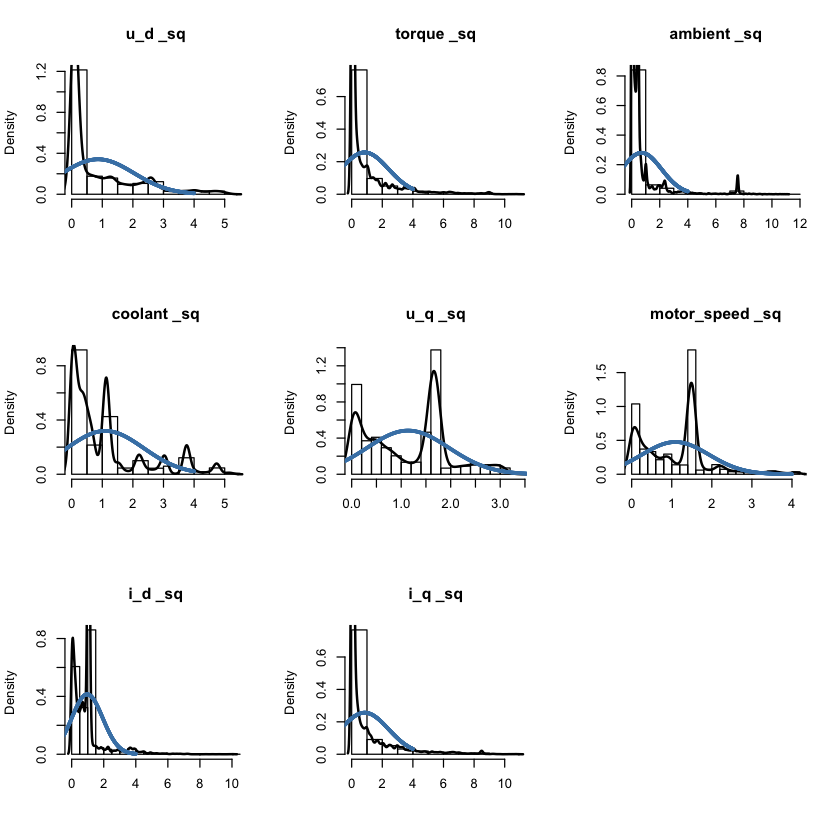

In [25]:
## FIGURE A8 ##

# square transformation histograms 

# create a grid for our plots 
par(mfrow=c(3,3))

# plot all columns of our data set as histograms 
for(i in 11:18){
    
    hist(data_transform[,i], main = names(data_transform)[i], breaks = 15, prob = T, xlab = '')
    
    
    # save mean and sd of each variable 
    # as well as parameters and distribution of a normal distribution
    var_sd <- sd(data_transform[,i])
    var_mean <- mean(data_transform[,i])
    normal_seq <- seq(from = - 4, to = 4, by = 0.0001)
    normal_dis <- dnorm(normal_seq, var_mean, var_sd)
    
    # plot varaible distribution curve
    lines(density(data_transform[,i]), col = "black", lwd = 2)
    
    # plot theoretical normal distribution of each features
    lines(normal_seq, normal_dis, col = "steelblue", lwd = 3)
}


##### II. Natural Log Transformation

In [26]:
# transform all features using the natural log transformation 'log(x)'
for(i in 1:len) {
    
    df_name <- paste(col_names[i],'_log')
    
    data_transform[df_name] <- log(data_transform[,i] + -(min(data_transform[,i])) + 0.0001)
    
}

In [27]:
head(data_transform)

u_d,torque,ambient,coolant,u_q,motor_speed,i_d,i_q,pm,profile_id,...,i_d _sq,i_q _sq,u_d _log,torque _log,ambient _log,coolant _log,u_q _log,motor_speed _log,i_d _log,i_q _log
-1.0267303,0.3586899,0.1176819,-1.040829,0.9250645,1.2124813,-0.8343090,0.3229330,-0.08831267,4,...,0.6960716,0.10428575,-0.4666796,1.301589,1.2370818,-1.628057,1.0078763,0.88995518,0.8511033,1.289701
-1.2258921,0.2841797,-0.5547717,-1.087189,0.5125759,2.0241232,-1.3638294,0.2340145,0.71040170,4,...,1.8600306,0.05476279,-0.8488209,1.281106,1.0199624,-1.897453,0.8447036,1.17762751,0.5948225,1.264913
0.2988575,-0.2591392,-0.7722329,-1.063652,0.9562448,-0.1402458,1.0291220,-0.2457111,-1.59260400,4,...,1.0590921,0.06037393,0.6691971,1.117533,0.9382985,-1.751652,1.0191927,0.07908234,1.4364314,1.119414
-1.0261079,0.3574240,0.2199584,-1.083475,0.9278145,1.2124836,-0.8381095,0.3228101,-0.14167030,4,...,0.7024276,0.10420636,-0.4656875,1.301244,1.2663335,-1.872985,1.0088796,0.88995612,0.8494794,1.289668
0.3155328,-0.2562895,0.4015749,-1.078981,-0.7094008,-0.9518901,1.0291730,-0.2457109,-1.96488810,4,...,1.0591971,0.06037382,0.6777005,1.118465,1.3162573,-1.844161,0.1001269,-1.30693213,1.4364435,1.119414
0.2999456,-0.2592790,-0.7697667,-1.089577,0.9589649,-0.1402460,1.0291333,-0.2457186,-1.77564350,4,...,1.0591153,0.06037763,0.6697541,1.117487,0.9392630,-1.913505,1.0201739,0.07908210,1.4364341,1.119411


#### <span style="color:blue"> Figure A9 - Histograms for predictor log transformations </span>

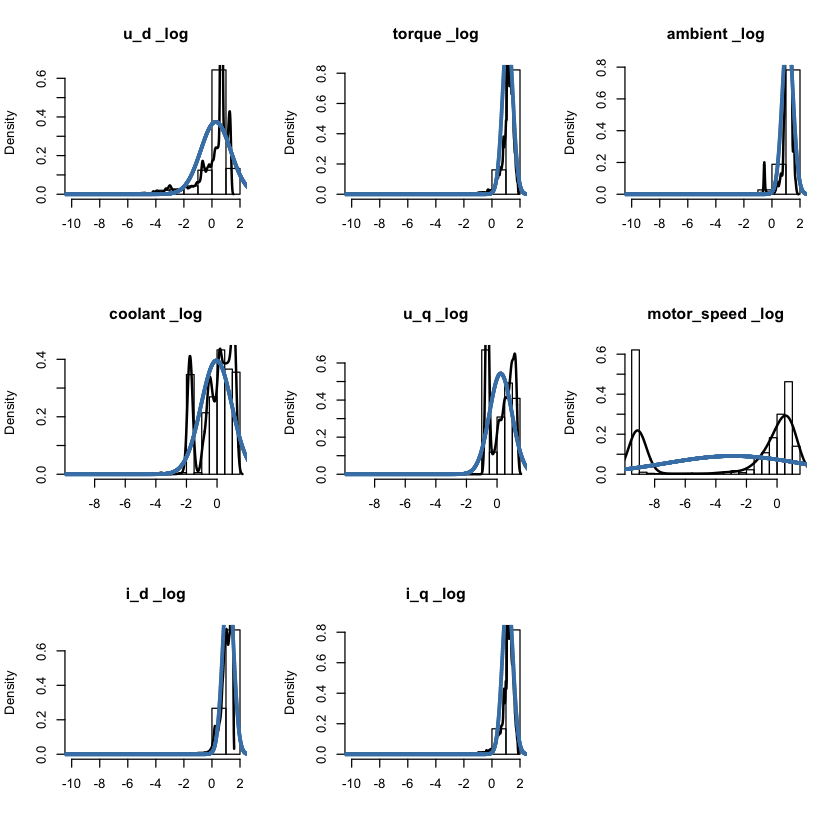

In [28]:
## FIGURE A9 ##

# natural log transformation histograms 

# create a grid for our plots 
par(mfrow=c(3,3))

# plot all columns of our data set as histograms 
for(i in 19:26) {
    
    hist(data_transform[,i], main = names(data_transform)[i], breaks = 15, prob = T, xlab = '')
    
    # adjustment made to observation to allow for transformation
    distribution_adj <- 4 + -(min(data_transform[,i]))+ 0.0001
    
    # save mean and sd of each variable 
    # as well as parameters and distribution of a normal distribution
    var_sd <- sd(data_transform[,i])
    var_mean <- mean(data_transform[,i])
    normal_seq <- seq(from = - distribution_adj, to = distribution_adj, by = 0.0001)
    normal_dis <- dnorm(normal_seq, var_mean, var_sd)
    
    # plot varaible distribution curve
    lines(density(data_transform[,i]), col = "black", lwd = 2)
    
    # plot theoretical normal distribution of each features
    lines(normal_seq, normal_dis, col = "steelblue", lwd = 3)
}

##### III. Cube Root Transformation

In [29]:
# transform all features using the cube root transformation 'x^(1/3)'
for(i in 1:len) {
    
    df_name <- paste(col_names[i],'_cube')
    
    data_transform[df_name] <- (data_transform[,i] + -(min(data_transform[,i])) + 0.0001)^(1/3)
    
}

In [30]:
head(data_transform)

u_d,torque,ambient,coolant,u_q,motor_speed,i_d,i_q,pm,profile_id,...,i_d _log,i_q _log,u_d _cube,torque _cube,ambient _cube,coolant _cube,u_q _cube,motor_speed _cube,i_d _cube,i_q _cube
-1.0267303,0.3586899,0.1176819,-1.040829,0.9250645,1.2124813,-0.8343090,0.3229330,-0.08831267,4,...,0.8511033,1.289701,0.8559358,1.543207,1.510379,0.5811852,1.399281,1.3453467,1.328036,1.537105
-1.2258921,0.2841797,-0.5547717,-1.087189,0.5125759,2.0241232,-1.3638294,0.2340145,0.71040170,4,...,0.5948225,1.264913,0.7535648,1.532707,1.404930,0.5312704,1.325206,1.4807408,1.219297,1.524456
0.2988575,-0.2591392,-0.7722329,-1.063652,0.9562448,-0.1402458,1.0291220,-0.2457111,-1.59260400,4,...,1.4364314,1.119414,1.2499027,1.451374,1.367202,0.5577279,1.404570,1.0267113,1.614153,1.452285
-1.0261079,0.3574240,0.2199584,-1.083475,0.9278145,1.2124836,-0.8381095,0.3228101,-0.14167030,4,...,0.8494794,1.289668,0.8562189,1.543030,1.525178,0.5356211,1.399749,1.3453471,1.327317,1.537087
0.3155328,-0.2562895,0.4015749,-1.078981,-0.7094008,-0.9518901,1.0291730,-0.2457109,-1.96488810,4,...,1.4364435,1.119414,1.2534505,1.451825,1.550771,0.5407922,1.033939,0.6468479,1.614160,1.452285
0.2999456,-0.2592790,-0.7697667,-1.089577,0.9589649,-0.1402460,1.0291333,-0.2457186,-1.77564350,4,...,1.4364341,1.119411,1.2501348,1.451352,1.367641,0.5284353,1.405029,1.0267112,1.614155,1.452283


#### <span style="color:blue"> Figure A10 - Histograms for predictor cube root transformations  </span>

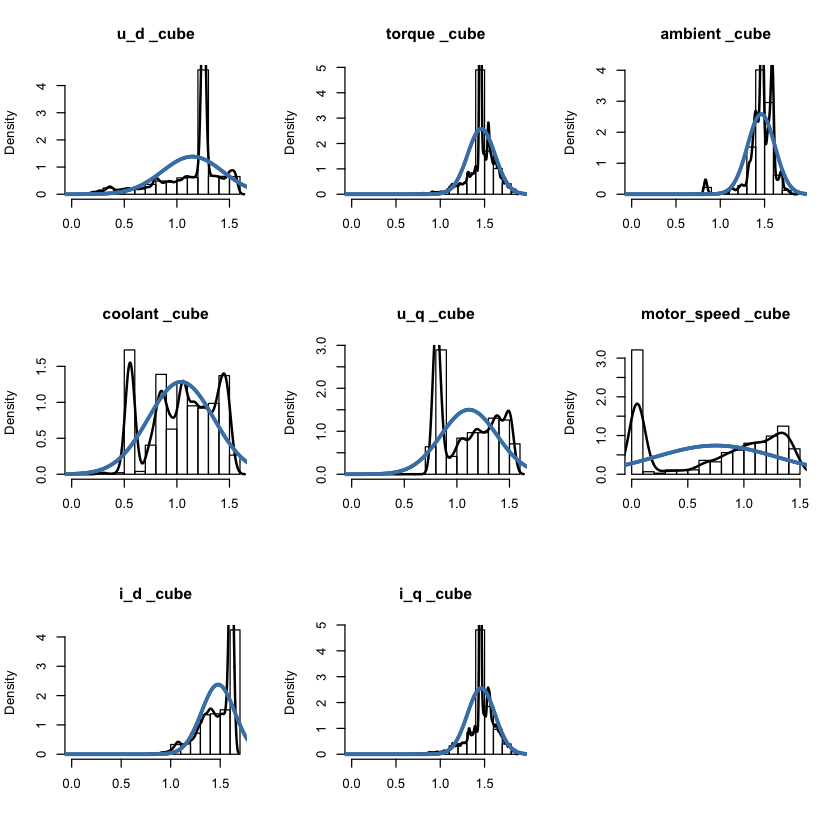

In [31]:
## FIGURE A10 ##

# cube root transformation histograms 

# create a grid for our plots 
par(mfrow=c(3,3))

# plot all columns of our data set as histograms 
for(i in 27:34) {
    
    hist(data_transform[,i], main = names(data_transform)[i], breaks = 15, prob = T, xlab = '')
    
    # adjustment made to observation to allow for transformation
    distribution_adj <- 4 + -(min(data_transform[,i]))+ 0.0001
    
    # save mean and sd of each variable 
    # as well as parameters and distribution of a normal distribution
    var_sd <- sd(data_transform[,i])
    var_mean <- mean(data_transform[,i])
    normal_seq <- seq(from = - distribution_adj, to = distribution_adj, by = 0.0001)
    normal_dis <- dnorm(normal_seq, var_mean, var_sd)
    
    # plot varaible distribution curve
    lines(density(data_transform[,i]), col = "black", lwd = 2)
    
    # plot theoretical normal distribution of each features
    lines(normal_seq, normal_dis, col = "steelblue", lwd = 3)
    
}

##### IV. Analysis

As one can see both the commonly useful square and natural log transformation were not able to create distributions that are closer to the normal distribution. This is due to both the extreme skewed and high kurtosis of many variables. The only transformation that was able to create 'more normal' distributions was the cube root transformation. Particularly coolant_cude and ambient_cube became 'more normally distributed.

## 4.1 Splitting data

After getting a better understanding of our data using EDA we can start the model building process.
Before we can build any model we need to split our data into test an training data sets. As the name implies the training data will be used to train our model, while the testing data is used to evaluate model performance by using data that the model has not seen before. This shows us how well a model would deal with new observations.

In [32]:
## we will split the data in training data and testing data
## all obseravtions with profile_id == 72 or profile_id == 81 will be used for testing

# remove any possible na values 
data_transform <- na.omit(data_transform)

index_test <- 1:nrow(data_transform[data_transform$profile_id == 72 | data_transform$profile_id == 81,])

# create traing data set
train_data <- data_transform[-index_test, ]
train_data <- subset(train_data, select = -c(profile_id))

# create testing data set
test_data <- data_transform[index_test, ]
test_data <- subset(test_data, select = -c(profile_id))

In [33]:
# check if the train/test data split worked 
dim(train_data)
dim(test_data)

[1] 9652   33

[1] 5495   33

In [34]:
# check train data
head(train_data)

,u_d,torque,ambient,coolant,u_q,motor_speed,i_d,i_q,pm,u_d _sq,...,i_d _log,i_q _log,u_d _cube,torque _cube,ambient _cube,coolant _cube,u_q _cube,motor_speed _cube,i_d _cube,i_q _cube
5496,-1.44572810,1.15668230,0.9637260,2.2614186,0.09216283,0.3412034,-0.9882069,1.07715010,0.59760666,2.090129739,...,0.7831395,1.4783992,0.5925782,1.647670,1.625072,1.5180859,1.240054,1.1607047,1.298288,1.636893
5497,-1.42379000,0.72248924,1.4339280,2.1769376,0.12296581,0.9448595,-1.2149063,0.63527590,1.47287430,2.027177964,...,0.6737769,1.3722068,0.6127115,1.592534,1.682377,1.5057670,1.246696,1.2941350,1.251812,1.579964
5498,-0.60309273,0.07515138,2.1417334,-0.6943905,1.39867700,1.5018992,-0.6003201,0.06523467,1.16551900,0.363720841,...,0.9463226,1.2161001,1.0166282,1.502454,1.761915,0.8157047,1.475665,1.3966653,1.370864,1.499852
5499,0.95540420,-0.64434580,1.6675345,0.6095884,1.59028780,0.5862430,0.3935017,-0.66222220,-0.04979382,0.912797185,...,1.2725769,0.9732557,1.3766916,1.387663,1.709451,1.2268768,1.504431,1.2184155,1.528355,1.383226
5500,0.62977750,-0.44083340,1.5792934,0.6095884,1.71344240,1.3555857,-0.2724236,-0.42853838,0.95283085,0.396619700,...,1.0661287,1.0578704,1.3168591,1.422034,1.699326,1.2268768,1.522355,1.3712016,1.426717,1.422795
5501,-0.09746816,0.18380223,0.8882484,-0.1818922,0.29722930,-0.4289657,0.9184657,0.27707896,0.28153480,0.009500042,...,1.4097678,1.2769950,1.1588711,1.518330,1.615489,1.0180866,1.283002,0.9258253,1.599870,1.530608


## 4.2 Multiple Linear Regression Model

####  Overview: 

Multiple linear regression is one of the most common and simple supervised regression models. It is used when a data set has mutiple predictors and a continuous target variable. The model is fitted to the data using the 'least squares method'.

####  Assumptions made: 

The three the main assumptions made for multiple linear regression are:

* normality of residuals
* independence of predictors
* linear relationship between predictors and target

Firstly, the residual error of predictions needs to be normaly distributed. Seconldly, the predictor variables are not correlated to another. Thirdly, that there is a linear realtionship between target and predictor variables.

####  Pros: 
* little complexity thus easy to evaluate and understand
* not demanding computationaly

####  Cons: 
* inflexiable since it is does poorly at modeling non linear relationships
* since it uses least squares estimates to fit the model it is sensitive to outliers 

##### I. Train Model

Train the Multiple Linear Regression Model using 'pm' as a traget and all other features as predictors. Based on the result from the EDA, I am excluding `torque` and `u_d` since they are strongly or perfectly correlated with other predictors with the correlation higher than 0.7. 

In [35]:
# using the target pm we create a MLR model using all predictors 
mlr_model <- lm(pm ~ ., data = train_data[3:9])

In [36]:
# display model summary
summary(mlr_model)


Call:
lm(formula = pm ~ ., data = train_data[3:9])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.17974 -0.43261 -0.05851  0.46147  2.15145 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.241528   0.007895 -30.591  < 2e-16 ***
ambient      0.641629   0.011825  54.259  < 2e-16 ***
coolant      0.269851   0.006654  40.553  < 2e-16 ***
u_q         -0.064943   0.016945  -3.832 0.000128 ***
motor_speed  0.147248   0.026481   5.560 2.76e-08 ***
i_d         -0.037592   0.017272  -2.176 0.029546 *  
i_q         -0.024247   0.008106  -2.991 0.002786 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6321 on 9645 degrees of freedom
Multiple R-squared:  0.3589,	Adjusted R-squared:  0.3585 
F-statistic: 900.1 on 6 and 9645 DF,  p-value: < 2.2e-16


As the summary shows all the predictor variables trained in the model are linearly associated with our target variable 'pm'. This is due to the fact that predictors such as 'ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', and 'i_q' all show statistically significant p-values under 0.05. Using a stepwise selection method, hybrid selection in this case, we can deselect some irrelevant features based on specified information criterions. With stepwise regression methods, we evaluate whether each available parameter increases model performance using information criterion, and remove or add the parameter to the models accordingly. 

##### II. Residual Error

After training the model we will check whether the residual error of the model is normally distributed. The residuals with non-random distribution or heteroskedaticity indicates that the multiple regression model is not suitable for predicting `pm` using linear models.

#### <span style="color:blue"> Figure A11 - Residual Error of Multiple Linear Regression Model </span>

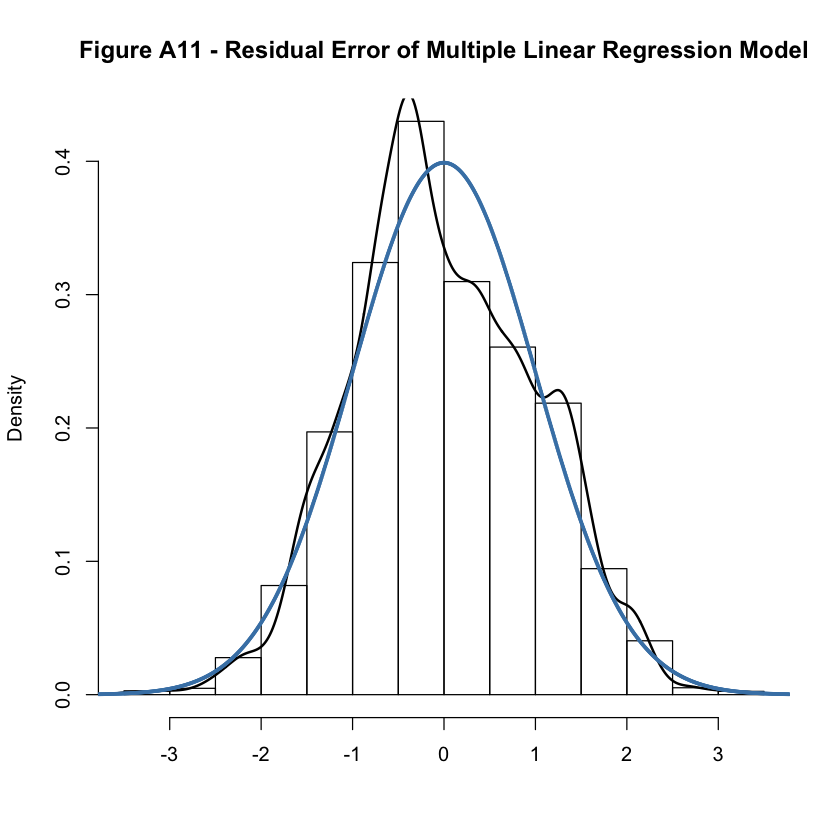

In [37]:
## FIGURE A11 ##

hist(rstandard(mlr_model), prob = T, main ='Figure A11 - Residual Error of Multiple Linear Regression Model', xlab = '')

# set properties of a Standard Normal Distribution
var_sd <- 1
var_mean <- 0
normal_seq <- seq(from = - 4, to = 4, by = 0.0001)
normal_dis <- dnorm(normal_seq, var_mean, var_sd)

# plot density curve of residual error distribution
lines(density(rstandard(mlr_model)), col = "black", lwd = 2)

# plot theoretical normal distribution 
lines(normal_seq, normal_dis, col = "steelblue", lwd = 3)

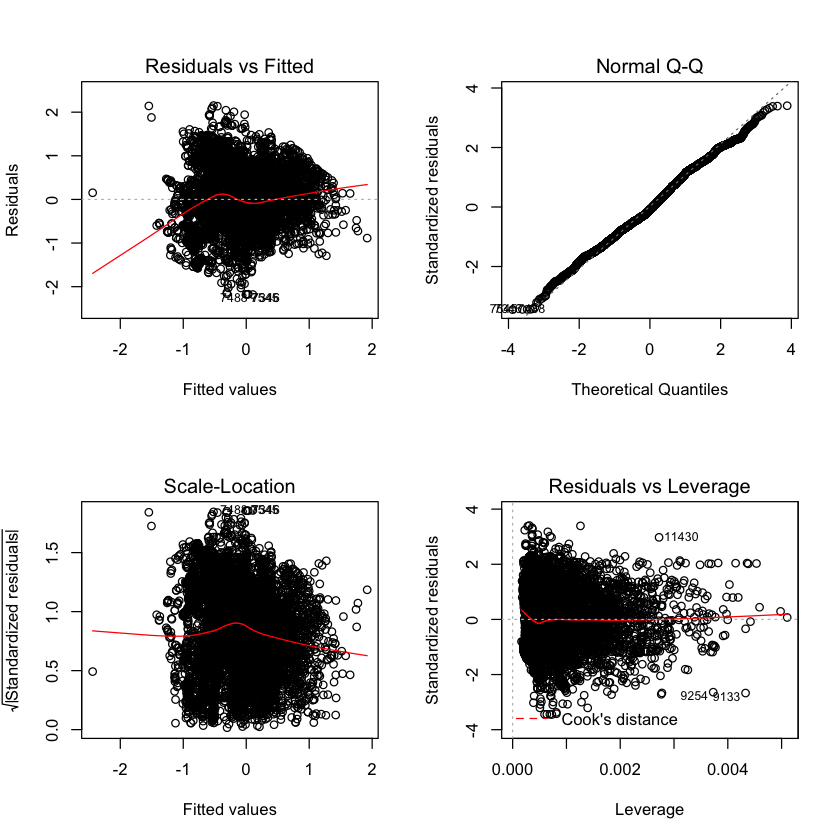

In [38]:
# create a grid for our plots 
par(mfrow=c(2,2))

# plot residuals of regression model 
plot(mlr_model)

Both the histogram of model residuals as well as the four different residual plots indicate that the residual values of the Multiple Linear Regression Model 'mlr_model' are normaly distributed. Moreover, no obvious outlier points can be detected. This means that we don't need to remove any observations due to their possible influence to the model.

#####  III. Stepwise Selection

After creating a model we need to assess which set of predictors is required to get the best model performance. In this case this is done using the Bayesian information criterion (BIC), represneted by k = log(n) in our selection process. This stepwise selection uses a hybrid selection method, which is a mixture of both forward and backward selection. 

In [39]:
# number of rows in our train dataframe, represents number of observations 
n <- dim(train_data)[1]

# we apply step() to perform the stepwise selection
# trace: in how many steps the information should be printed
# direction: the direction of the testing, which was specified to both
# k: the number of degrees of freedom of the Bayesian information criterion
sw_mlr_model <- step(mlr_model, trace = 0 ,direction = 'both', k = log(n))

In [40]:
# display model summary
summary(sw_mlr_model)


Call:
lm(formula = pm ~ ambient + coolant + u_q + motor_speed, data = train_data[3:9])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.18926 -0.43317 -0.06287  0.46195  2.14335 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.238113   0.007502 -31.738  < 2e-16 ***
ambient      0.644677   0.011798  54.644  < 2e-16 ***
coolant      0.268362   0.006622  40.523  < 2e-16 ***
u_q         -0.089128   0.012587  -7.081 1.53e-12 ***
motor_speed  0.196883   0.013302  14.801  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6324 on 9647 degrees of freedom
Multiple R-squared:  0.3582,	Adjusted R-squared:  0.3579 
F-statistic:  1346 on 4 and 9647 DF,  p-value: < 2.2e-16


After hybrid selection the model is left with four predictors which are:

* ambient      0.644677
* coolant      0.268362
* u_q         -0.089128
* motor_speed  0.196883

Based on the feature coefficients we can expect ambient, coolant, and motor_speed to have the largest impact on the target pm. Despite the models low complexity the model appears to perform reasonably well on the trainging data, given it's Multiple R-squared value of 0.3582. This, is however only training data performance and we will check the models test performance using unsee data at the end of this project.

#####  IV. Prediction

Using the above created model will test it on our testing data.

In [41]:
# make predictions using the final Multiple Linear Regression Model and
# save predictions as pred_mlr_model
pred_mlr_model <- predict(sw_mlr_model, test_data)

## 4.3 Polynomial Regression Model

####  Overview: 

Polynomial Regression is based on multiple linear regression with some adjustments. The main adjustment is the relaxation of the linearity requirement. This makes polynomial regression a more flexiable, since we are able to fit it to some non-linear relationships. It is used when a data set has mutiple predictors and a continuous target variable. The model is fitted to the data using the 'least squares method' similar to multiple linear regression.

####  Assumptions made: 

The assumptions made for polynomial regression are the same as for multiple linear regression. They are:

* normality of residuals
* independence of predictors
* linear or curvilinear relationship between predictors and target

Firstly, the residual error of predictions needs to be normaly distributed. Seconldly, the predictor variables are not correlated to another. Thirdly, that there is a linear or curvilinear realtionship between target and predictor variables.

####  Pros: 
* more flexiable than multiple linear regression
* relative little complexity thus easy to evaluate and understand
* not demanding computationaly

####  Cons: 
* more complex than multiple linear regression thus harder to interpret
* since it uses least squares estimates and ploynomial terms to fit the model it is very sensitive to outliers 


##### I. Train Model

Train the Polynomial Regression Model using 'pm' as a traget and all features, interaction terms, features with polynomial, natural log, and cube transformation as predictors.

In [42]:
# build a polynomial regression with different kinds of transformations and interactions
pr_model <- lm(pm ~ .*.
               
                # polynomial transformations until 2
                + poly(ambient,2) + poly(coolant,2) + poly(u_q,2) 
                + poly(motor_speed,2) + poly(i_d,2) + poly(i_q,2) 
                
                # natural log transforations + constant for negative or 0 values
                + log(ambient + -(min(ambient)) + 0.0001) + log(coolant + -(min(coolant)) + 0.0001)  
                + log(u_q + -(min(u_q)) + 0.0001) + log(motor_speed + -(min(motor_speed)) + 0.0001) 
                + log(i_d + -(min(i_d)) + 0.0001) + log(i_q + -(min(i_q)) + 0.0001)
               
                # cube root transformation
                + I((ambient + -(min(ambient)) + 0.0001)^(1/3)) + I((coolant + -(min(coolant)) + 0.0001)^(1/3)) 
                + I((u_q + -(min(u_q)) + 0.0001)^(1/3)) + I((motor_speed + -(min(motor_speed)) + 0.0001)^(1/3)) 
                + I((i_d + -(min(i_d)) + 0.0001)^(1/3)) + I((i_q + -(min(i_q)) + 0.0001)^(1/3))
                
               # data used training
               ,data = train_data[3:9])


In [43]:
# display model summary
summary(pr_model)


Call:
lm(formula = pm ~ . * . + poly(ambient, 2) + poly(coolant, 2) + 
    poly(u_q, 2) + poly(motor_speed, 2) + poly(i_d, 2) + poly(i_q, 
    2) + log(ambient + -(min(ambient)) + 1e-04) + log(coolant + 
    -(min(coolant)) + 1e-04) + log(u_q + -(min(u_q)) + 1e-04) + 
    log(motor_speed + -(min(motor_speed)) + 1e-04) + log(i_d + 
    -(min(i_d)) + 1e-04) + log(i_q + -(min(i_q)) + 1e-04) + I((ambient + 
    -(min(ambient)) + 1e-04)^(1/3)) + I((coolant + -(min(coolant)) + 
    1e-04)^(1/3)) + I((u_q + -(min(u_q)) + 1e-04)^(1/3)) + I((motor_speed + 
    -(min(motor_speed)) + 1e-04)^(1/3)) + I((i_d + -(min(i_d)) + 
    1e-04)^(1/3)) + I((i_q + -(min(i_q)) + 1e-04)^(1/3)), data = train_data[3:9])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.92966 -0.33992 -0.03475  0.32640  2.47579 

Coefficients: (6 not defined because of singularities)
                                                       Estimate Std. Error
(Intercept)                                           -6.99745

The 'pr_model' polynomial regression model has 39 features. Not all of these 39 features actually add value to the model, but rather in this approach we applied common transformation techniques in an attempt to create useful features. In the next step we wil remove all useless features using stepwise selection.

##### II. Residual Error

After training the model we will check whether the residual error of the model is normally distributed. This is important to confirm since normaly distributed error is one of the assumptions of polynomial regression.

#### <span style="color:blue"> Figure A12 - Residual Error of Polynomial Regression Model </span>

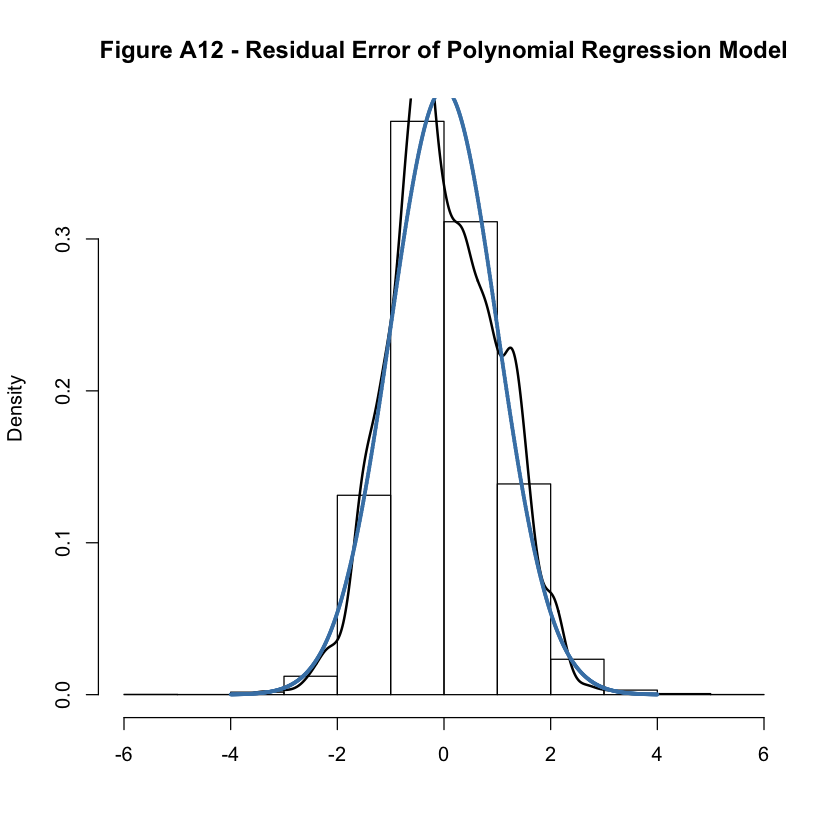

In [44]:
## FIGURE A12 ##

hist(rstandard(pr_model), prob = T, main ='Figure A12 - Residual Error of Polynomial Regression Model', xlab = '')

# set properties of a Standard Normal Distribution
var_sd <- 1
var_mean <- 0
normal_seq <- seq(from = - 4, to = 4, by = 0.0001)
normal_dis <- dnorm(normal_seq, var_mean, var_sd)

# plot density curve of residual error distribution
lines(density(rstandard(mlr_model)), col = "black", lwd = 2)

# plot theoretical normal distribution 
lines(normal_seq, normal_dis, col = "steelblue", lwd = 3)

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs wurden erzeugt”
Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs wurden erzeugt”


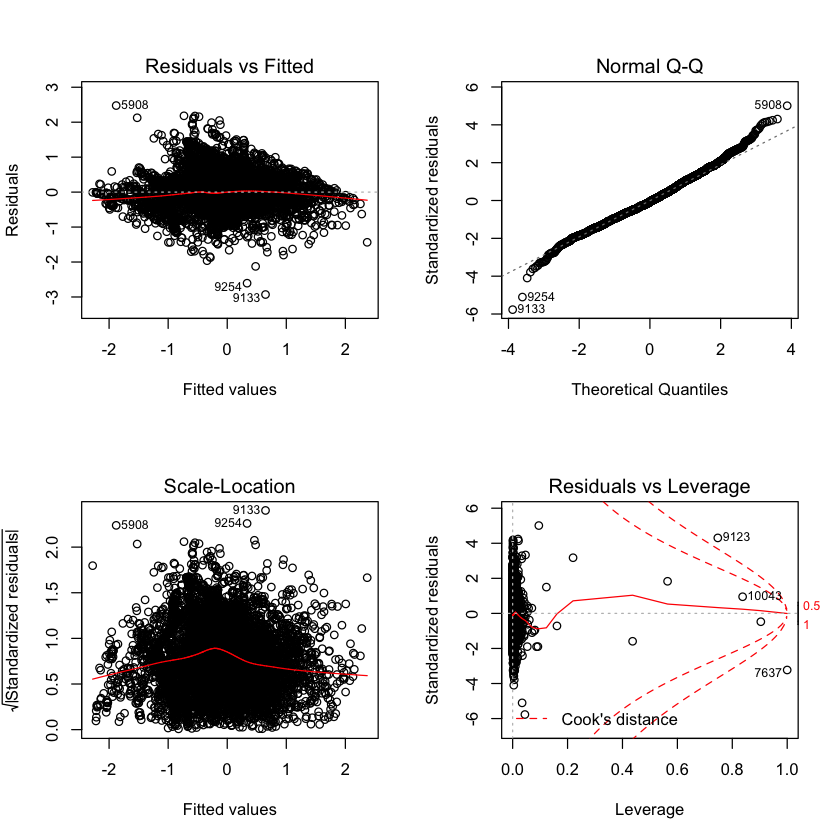

In [45]:
# create a grid for our plots 
par(mfrow=c(2,2))

# plot residuals of regression model 
plot(pr_model)

Both the histogram of model residuals as well as the four different residual plots indicate that the residual values of the Polynomial Regression Model 'pr_model' are roughly normally distributed. 

Based on the Cook's distance we can determine two main outliers, osbervations 9123 and 7637. However, the 'Residuals vs Fitted' plot in th top left indicates that they don't have a significant impact on the model. Thus, they will not be removed and no adjustments to the model need to be made.

#####  III. Stepwise Selection

After creating a model we need to assess which set of predictors is required to get the best model performance. In this case this is done using the Bayesian information criterion (BIC), represneted by k = log(n) in our selection process. This stepwise selection uses a hybrid selection methode, which is a mixture of both forward and backward selection. 

In [46]:
# number of observations 
n <- dim(train_data)[1]

# same as above we use hybrid selection to remove all features that don't enhance model performance 
# k = information cirterion (Basian Information Cirterion) RMSE - something*number of features
sw_pr_model <- step(pr_model, trace = 0 ,direction = 'both', k = log(n))

# display model summary after stepwise selection
summary(sw_pr_model)


Call:
lm(formula = pm ~ ambient + coolant + u_q + motor_speed + i_d + 
    i_q + poly(ambient, 2) + poly(coolant, 2) + poly(motor_speed, 
    2) + poly(i_q, 2) + log(ambient + -(min(ambient)) + 1e-04) + 
    log(motor_speed + -(min(motor_speed)) + 1e-04) + log(i_d + 
    -(min(i_d)) + 1e-04) + I((ambient + -(min(ambient)) + 1e-04)^(1/3)) + 
    I((coolant + -(min(coolant)) + 1e-04)^(1/3)) + I((u_q + -(min(u_q)) + 
    1e-04)^(1/3)) + I((motor_speed + -(min(motor_speed)) + 1e-04)^(1/3)) + 
    I((i_d + -(min(i_d)) + 1e-04)^(1/3)) + ambient:u_q + ambient:motor_speed + 
    ambient:i_d + coolant:u_q + coolant:motor_speed + coolant:i_d + 
    coolant:i_q + motor_speed:i_d + motor_speed:i_q + i_d:i_q, 
    data = train_data[3:9])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.92910 -0.34196 -0.03621  0.32627  2.51913 

Coefficients: (4 not defined because of singularities)
                                                       Estimate Std. Error
(Intercept)                  

After the stepwise selection we are left with 28 features in the polynomial regression model. That means that out of the inital 39 features only 28 of them actually add value to the model and are thus kept. Due to the large number of features it is a harder to interpret the model. The features used in our polynomial regression can be split into four groups: original features, ploynomial transformed features, log transformed features, cube transformed features, and interaction terms.

|Features used | Coefficent
------------- | -------------:
ambient           |                                    -3.198
coolant             |                                  17.250
u_q                  |                                -55.014
motor_speed             |                              51.644
i_d                     |                              47.970
i_q                     |                              47.660
poly(ambient)2           |                              3.538
poly(coolant)2             |                          -21.198
poly(motor_speed)2          |                         -17.862
poly(i_q)2                  |                           7.637
log(ambient)                 |                         -3.611
log(motor_speed)              |                        13.643
log(i_d)                      |                         8.189
I((ambient)^(1/3))            |                         3.708
I((coolant)^(1/3))            |                       -16.570
I((u_q)^(1/3))                 |                       27.239
I((motor_speed)^(1/3))        |                       -19.071
I((i_d)^(1/3))                  |                     -17.985
ambient:u_q                    |                        9.038
ambient:motor_speed            |                      -11.885
ambient:i_d                    |                       -6.426
coolant:u_q                    |                        6.677
coolant:motor_speed           |                       -14.365
coolant:i_d                   |                       -11.132
coolant:i_q                   |                        -4.496
motor_speed:i_d                |                       54.630
motor_speed:i_q               |                        17.923
i_d:i_q                       |                        17.951

As the model summary and their feature coefficients show the most influential features in the model were six original features ambient, coolant, u_q, motor_speed, i_d, and i_q as well as the interaction term motor_speed:i_d and the cube root of u_q.

In terms of performance, despite all the added features to the model, this polynomial regression performed worse in training than the original Multiple Linear Regression Model. Thus, the added model complexity did not increase performance.

#####  IV. Prediction

Using the above created model will test it on our testing data.

In [47]:
# make predictions using the final Polynomial Regression Model and
# save predictions as pred_pr_model
pred_pr_model <- predict(sw_pr_model, test_data)

Warning message in predict.lm(sw_pr_model, test_data):
“prediction from a rank-deficient fit may be misleading”


## 4.4 Ridge Regression Model

####  Overview: 

The main difference between the Ridge Regression Model and regular least squares regression is, that it uses a shrinkage estimator where it penalizes each predictor by sum of squared coefficients, instead of using the unbiased estimator. This enables Ridge Regression to differentiate between valueable and less valuable features in our training process. Less valuable features are shrunk to a minimum to reduce their impact.

####  Assumptions made: 

The assumptions made for ridge regression are simialar to multiple linear regression.
They are:

* independence of predictors
* linear or curvilinear relationship between predictors and target

Despite these assumptions the Ridge Regression still perfroms well even if not all assumptions are met.

####  Pros: 
* is able to differentiate between valueable and less valuebable features & shrinks less valueable features to a minimum 
* prevents overfitting
* is able to deal with collinearity between perdictors in the data set
* this model centric approach does not require residula error to be normaly distributed

####  Cons: 
* more computationally complex than multiple linear regression
* considers all features provided and can't eliminate useless features
* sensitive to outliers 


#####  I. Pre Process Data

Firstly, before we can train the ridge regression model we need to save the x input in matrix format for the glmnet() function. 

In [48]:
# save model training input in matrix format 
y_train <- data.matrix(train_data['pm'], rownames.force = NA)
x_train <- data.matrix(subset(train_data, select = -c(pm)), rownames.force = NA)


# save model testing input in matrix format 
y_test <- data.matrix(test_data['pm'], rownames.force = NA)
x_test <- data.matrix(subset(test_data, select = -c(pm)), rownames.force = NA)

#####  II. Find Lambda

Secondly, we need to find the optimal value for the model parameter lambda. This is done  through cross validation, using the cv.glmnet() function. Later we build multiple models with each value for lambda select the lambda with the best prediction performance.

In [49]:
#  using cv.glmnet() we perform k-fold cross-validation for glmnet to select for the best lambda value
cv_ridge_model <- cv.glmnet(x = x_train[,1:8] , y = y_train , alpha = 0)

# lambda.min returns us the value of lambda that has the smallest mean error
best_lam <- cv_ridge_model$lambda.min

best_lam

[1] 0.04103717

##### III. Train Model

In [50]:
# using glmnet() we fit the elastic net regression model
ridge_model <- glmnet(x = x_train[,1:8] , y = y_train , alpha = 0)

#### <span style="color:blue"> Figure A13 - Lambda Selection Plots for Ridge Regression </span>

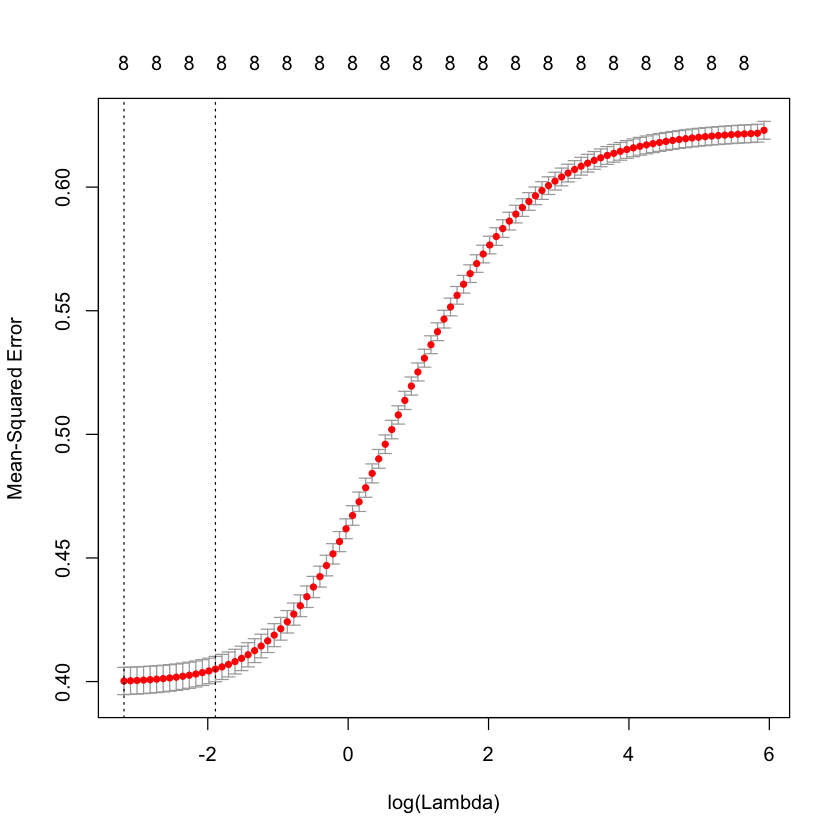

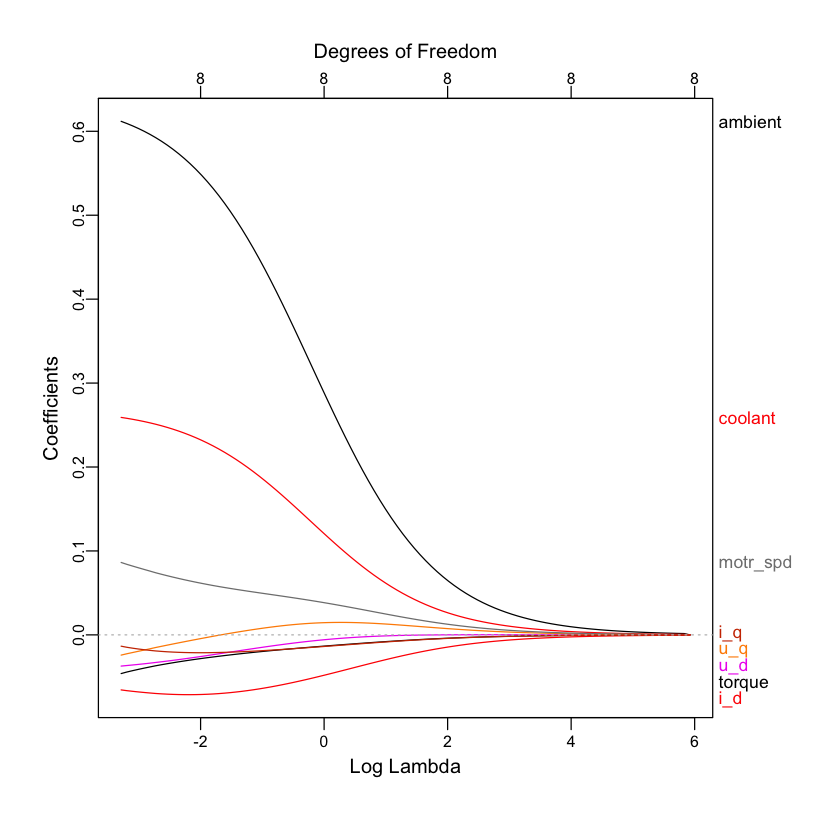

In [51]:
## FIGURE A13 ##

# plot out the MSE associated with the level of lambda
plot(cv_ridge_model)

# plot out the the coefficients of features with the level of lambda
plot_glmnet(x = ridge_model, xvar = "lambda", s = best_lam, label = TRUE)

Firstly, the cross validation shows us which lambda value provides us with the lowest MSE for our model. Secondly, as the graph above is showing ambient and coolant seem to be one of the most relevant features since they shrink the slowest as lambda increases. 

We won't be checking whether the residual error of shrinkage methods is normally distributed since the model does not assume normality for its residual error.

#####  IV. Prediction

Using the above created model will test it on our testing data.

In [52]:
# make predictions using the final Ridge Regression Model and
# save predictions as pred_ridge_model
pred_ridge_model <- predict(ridge_model, s = best_lam , newx = x_test[,1:8])

In [53]:
# display coefficients model useses
predict(ridge_model, s = best_lam, type = "coefficients")

9 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) -0.23198814
u_d         -0.03652376
torque      -0.04424297
ambient      0.60925895
coolant      0.25801810
u_q         -0.02249627
motor_speed  0.08401253
i_d         -0.06648191
i_q         -0.01479300

Similar to the above seen graph the coefficient summary shows that ambient and coolant are the most relevant features in predicting the target pm.

Out of all 8 available predictors the Ridge Model used:

* u_d         -0.03652376
* torque      -0.04424297
* ambient      0.60925895
* coolant      0.25801810
* u_q         -0.02249627
* motor_speed  0.08401253
* i_d         -0.06648191
* i_q         -0.01479300

Both ambient and coolant have the largest effect on pm with coefficients of 0.61 and 0.26. This result was expectable since during the EDA process it became apperant that ambient had a correlation of 0.5 and coolant a correlation of 0.3 to the target feature pm.

## 4.5 Lasso Regression Model

####  Overview: 

Lasso Regression is simialar to Ridge Regression, since both models use a shrinkage estimator instead of using the unbiased estimator like regular least squares regression. It penalizes each predictor by the sum of absolute values of the coefficients to shrink predictors. This enables Lasso Regression to differentiate between valueable and less valuebable features in our training process. Less valuabel features are shrunk to zero to remove their impact.

####  Assumptions made: 


There is only one assumptions made for Lasso regression. It is assumed that there is a linear or curvilinear relationship between predictors and target. All other assumptions are relaxed, which makes the model great for data with large collinearity between perdictors.

####  Pros: 
* is able to differentiate between valueable and less valuebable features & shrinks less valueable features to zero
* prevents overfitting
* is able to remove useless features completly
* is able to deal with collinearity between perdictors in the data set
* this model centric approach does not require residual error to be normaly distributed

#### Cons:
* more computationally complex than multiple linear regression
* sensitive to outliers 



#####  I. Find Lambda

Secondly, we need to find the optimal value for the model parameter lambda. This is done  through cross validation, using the cv.glmnet() function. Later we build multiple models with each value for lambda select the lambda with the best prediction performance.

In [54]:
#  using cv.glmnet() we perform k-fold cross-validation for glmnet to select for the best lambda value
cv_lasso_model <- cv.glmnet(x = x_train , y = y_train , alpha = 1)

# lambda.min returns us the value of lambda that has the smallest mean error
best_lam <- cv_lasso_model$lambda.min

best_lam

[1] 6.534278e-05

##### II. Train Model

In [55]:
# using glmnet() we fit the elastic net regression model
lasso_model <- glmnet(x = x_train , y = y_train, alpha = 1)

#### <span style="color:blue"> Figure A14 - Lambda Selection Plots for Lasso Regression </span>

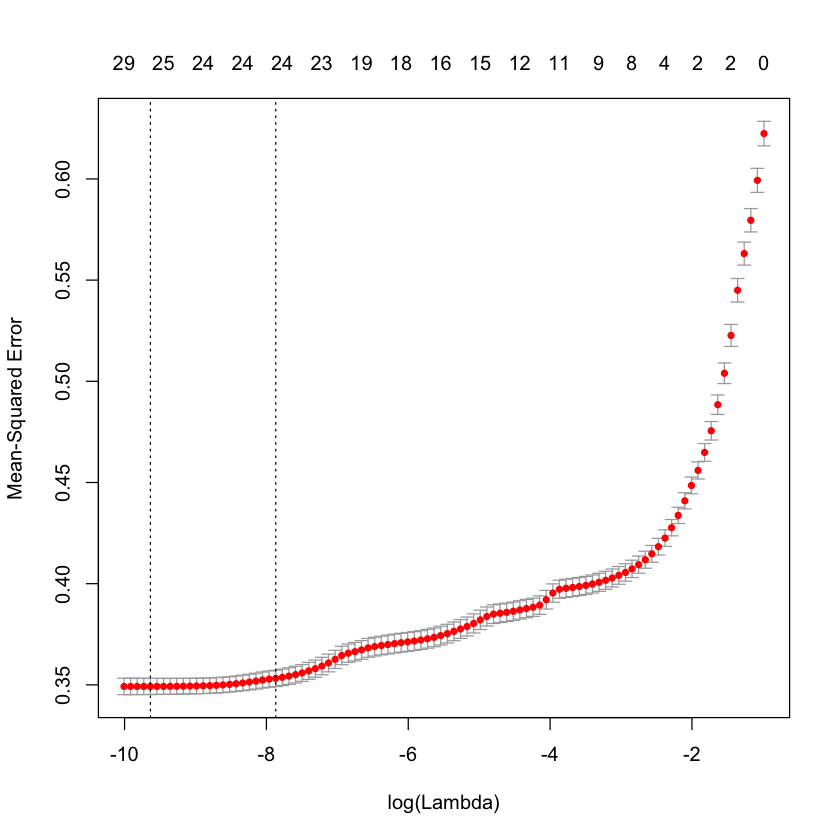

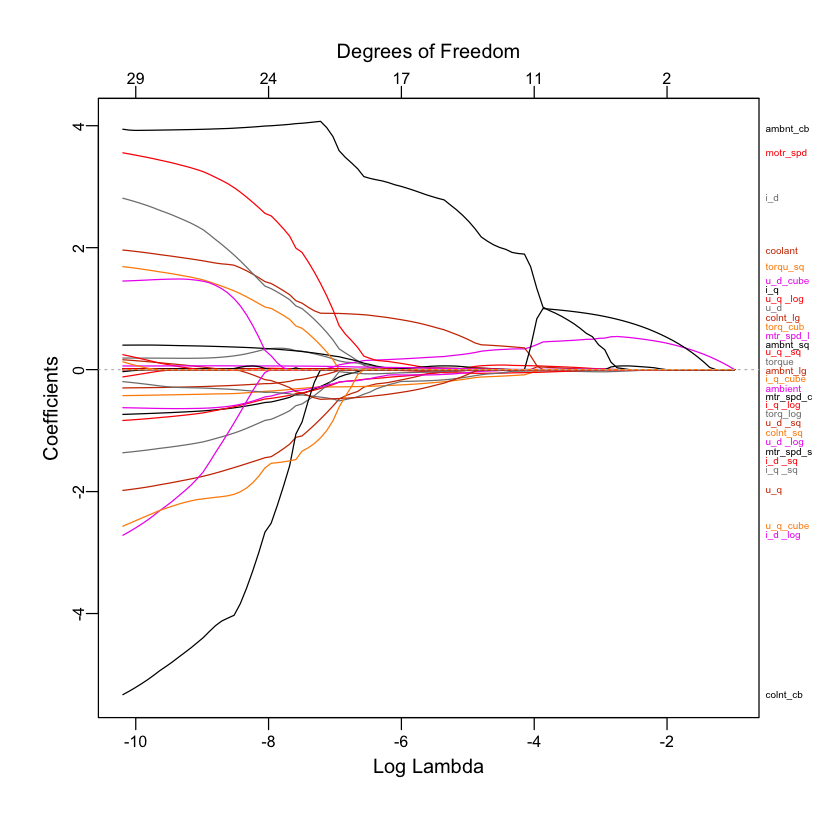

In [56]:
## FIGURE A14 ##

# plot out the MSE associated with the level of lambda
plot(cv_lasso_model)

# plot out the the coefficients of features with the level of lambda
plot_glmnet(x = lasso_model, xvar = "lambda",s = best_lam, label=TRUE)

Firstly, the cross validation shows us which lambda value provides us with the lowest MSE for our model. Secondly, as the graph above is showing ambient_sq, motor_speed, motor_speed _sq, i_d, coolant_sq, and u_q_cube seem to be one of the most relevant features since they shrink the slowest as lambda increases.

We won't be checking whether the residual error of shrinkage methods is normally distributed since the model does not assume normality for its residual error.

#####  III. Prediction

Using the above created model will test it on our testing data.

In [57]:
# make predictions using the final Ridge Regression Model and
# save predictions as pred_lasso_model
pred_lasso_model <- predict(lasso_model, s = best_lam , newx = x_test)

In [58]:
# display coefficients model useses
predict(lasso_model, s = best_lam, type = "coefficients")

33 x 1 sparse Matrix of class "dgCMatrix"
                              1
(Intercept)        4.798376e+00
u_d                1.881369e-01
torque             .           
ambient            .           
coolant            1.885680e+00
u_q               -1.887786e+00
motor_speed        3.435686e+00
i_d                2.611542e+00
i_q                4.009021e-01
u_d _sq           -2.930153e-01
torque _sq         1.602613e+00
ambient _sq        1.640171e-02
coolant _sq       -4.163722e-01
u_q _sq            6.751504e-03
motor_speed _sq   -7.120363e-01
i_d _sq           -7.858277e-01
i_q _sq           -1.290961e+00
u_d _log          -6.369270e-01
torque _log       -2.674888e-01
ambient _log       .           
coolant _log       1.115142e-01
u_q _log           1.070246e-01
motor_speed _log   6.030258e-02
i_d _log          -2.309742e+00
i_q _log          -2.343032e-02
u_d _cube          1.478820e+00
torque _cube       4.334255e-06
ambient _cube      3.928212e+00
coolant _cube     -4.935012e+0

The lasso regression uses 29 features in the model. That means that out of the inital 32 available features only 29 of them actually add value to the model and are thus not shrunk to 0. Due to the large number of features it is a harder to interpret the model. The features used in our lasso regression can be split into four groups: original features, ploynomial transformed features, log transformed features, and cube transformed features.


|Features used | Coefficent
------------- | -------------:
u_d         |       1.895523e-01
torque      |       1.887706e-03
ambient     |      -3.653251e-05
coolant     |       1.939135e+00
u_q         |      -1.954716e+00
motor_speed  |      3.518510e+00
i_d         |       2.753808e+00
i_q          |      4.025441e-01
u_d _sq |          -2.979657e-01
torque _sq        | 1.663750e+00
ambient _sq   |     1.648915e-02
coolant _sq   |    -4.235672e-01
u_q _sq       |     1.359940e-02
motor_speed _sq |  -7.273601e-01
i_d _sq       |    -8.201119e-01
i_q _sq        |   -1.341851e+00
u_d _log       |   -6.282860e-01
torque _log    |   -2.178926e-01
coolant _log   |    1.473478e-01
u_q _log       |    2.005514e-01
motor_speed _log |  5.986119e-02
i_d _log       |   -2.599814e+00
i_q _log       |   -8.750791e-02
u_d _cube       |   1.460164e+00
torque _cube    |   7.103565e-02
ambient _cube   |   3.923120e+00
coolant _cube   |  -5.215688e+00
u_q _cube       |  -2.480326e+00
motor_speed _cube | -1.305140e-02


As the model summary and their feature coefficients show the most influential features in the model were ambient_sq, motor_speed, motor_speed _sq, i_d, coolant_sq, and u_q_cube.

# <em> 5. Results and Discussion <a class="anchor" id="sec_6"></a> <em>

After training four different models we will now compare their properties and performance. For peformance measurement we will use the measures R Squared, Mean Squared Error (MSE), and Root Mean Square Error (RMSE). To calculate these we have defined the three functions below. Four different model will be assessed:

* multi linear regression

* polynomial regression 

* ridge regression

* lasso regression

In [59]:
# R squared evaluation function
RSQ <- function (predicted, target){
    
    rsq <- cor(predicted, target)^2
    
    return (round(rsq, digits = 3))
}

In [60]:
# MSE evaluation function
MSE <- function(predicted, target) {
    
    se <- (predicted - target)^2
    
    mse <- mean(se)
    
    return (round(mse, digits = 3))
}

In [61]:
# RMSE evaluation function
RMSE <- function(predicted, target) {
    
    se <- (predicted - target)^2
    
    rmse <- sqrt(mean(se))
    
    return (round(rmse, digits = 3))
}

Now we will calculate the models performance.

####  R Squared

In [62]:
# calculate R^2 for each model

cat('The R Squared for multi linear regression is:\t' , RSQ(pred_mlr_model,test_data[,'pm']), '\n')
cat('The R Squared for polynomial regression is:\t' , RSQ(pred_pr_model,test_data[,'pm']), '\n')
cat('The R Squared for ridge regression is:\t\t' , RSQ(pred_ridge_model,test_data[,'pm']), '\n')
cat('The R Squared for lasso regression is:\t\t' , RSQ(pred_lasso_model,test_data[,'pm']), '\n')

The R Squared for multi linear regression is:	 0.418 
The R Squared for polynomial regression is:	 0.248 
The R Squared for ridge regression is:		 0.41 
The R Squared for lasso regression is:		 0.416 


R Squared measures how well a regression model fits to the observed data. It shows the percentage of the variance in the target variable that the predictor variables are able to explain. The larger the R Squared value the better the model fits the data. One of the main problems of R Squared, however, is that it does not penalize biased models, thus, other measures such as MSE and RMSE need to be considered when judgeing the performance of a model.

As the above calculations show that the lasso regression model has the highest test R Squared value of all four models. This, makes sense since the R Squared of a model commonly increases with the number of relevant predictors it has. in this case the lasso regression model contains 19 predictors which should increase the R Squared value.
In some cases, such as our polynomial regression the use of more predictors does not lead to better performance. Our polynomial regression model contains 28 predictors but only achieves an R Squared value of 0.248.

####  Mean Square Error

In [63]:
# calculate MSE for each model
cat('The Mean Square Error for multi linear regression is:\t' , MSE(pred_mlr_model,test_data[,'pm']), '\n')
cat('The Mean Square Error for polynomial regression is:\t' , MSE(pred_pr_model,test_data[,'pm']), '\n')
cat('The Mean Square Error for ridge regression is:\t\t' , MSE(pred_ridge_model,test_data[,'pm']), '\n')
cat('The Mean Square Error for lasso regression is:\t\t' , MSE(pred_lasso_model,test_data[,'pm']), '\n')

The Mean Square Error for multi linear regression is:	 0.938 
The Mean Square Error for polynomial regression is:	 2.569 
The Mean Square Error for ridge regression is:		 0.921 
The Mean Square Error for lasso regression is:		 0.978 


Mean Square Error measures the average error of the predictions our model made. It does that by calculating the error of each prediction, squaring it, and the summing the squared error terms and taking their mean. The Mean Square Error is a tradeoff between the variance and bias of a model and tells us how close we are to the line of best fit of the data. The smaller the MSE value the better.

In our case the ridge regression achieved the lowest MSE. Since ridge regression is able to deal with collinearity between perdictors, as it is the case with our data set, and is able to differenciate between valueable and less valuebable features, it is expactable that ridge regression would do better than multi linear regression which is based on maximum likelihood estimator.

####  R Squared

In [64]:
# calculate the Root Mean Square Error for each model
cat('The Root Mean Square Error for multi linear regression is:\t' , RMSE(pred_mlr_model,test_data[,'pm']), '\n')
cat('The Root Mean Square Error for polynomial regression is:\t' , RMSE(pred_pr_model,test_data[,'pm']), '\n')
cat('The Root Mean Square Error for ridge regression is:\t\t' , RMSE(pred_ridge_model,test_data[,'pm']), '\n')
cat('The Root Mean Square Error for lasso regression is:\t\t' , RMSE(pred_lasso_model,test_data[,'pm']), '\n')

The Root Mean Square Error for multi linear regression is:	 0.969 
The Root Mean Square Error for polynomial regression is:	 1.603 
The Root Mean Square Error for ridge regression is:		 0.96 
The Root Mean Square Error for lasso regression is:		 0.989 


Similar to MSE the Root Mean Square Error measures how close the model is to the line of best fit of the data.
RMSE takes the root of  the squared error terms and then averages them by summing theh up and taking their mean.


In our case the ridge regression achieved the lowest RMSE vaue as well. Since ridge regression is able to deal
with collinearity between perdictors, as it is the case with our data set, and is able to differenciate
between valueable and less valuebable features, it is expactable that ridge regression would do better
than multi linear regression which is based on maximum likelihood estimator.

Append all results to a dataframe to plot them.

In [65]:
# append 'Multiple Linear Regression' results
performance_df <- data.frame(model = 'Multiple Linear Regression',
                                RSQ = RSQ(pred_mlr_model,test_data[,'pm']),
                                MSE = MSE(pred_mlr_model,test_data[,'pm']),
                                RMSE = RMSE(pred_mlr_model,test_data[,'pm']))

# append 'Polynomial Regression' results
performance_df <- rbind(performance_df, data.frame(model = 'Polynomial Regression',
                                                    RSQ = RSQ(pred_pr_model,test_data[,'pm']), 
                                                    MSE = MSE(pred_pr_model,test_data[,'pm']),
                                                    RMSE = RMSE(pred_pr_model,test_data[,'pm'])))


# append 'Ridge Regression Model' results
performance_df <- rbind(performance_df, data.frame(model = 'Ridge Regression Model',
                                                    RSQ = RSQ(pred_ridge_model,test_data[,'pm']), 
                                                    MSE = MSE(pred_ridge_model,test_data[,'pm']),
                                                    RMSE = RMSE(pred_ridge_model,test_data[,'pm'])))

# append 'Lasso Regression Model' results
performance_df <- rbind(performance_df, data.frame(model = 'Lasso Regression Model',
                                                    RSQ = RSQ(pred_lasso_model,test_data[,'pm']), 
                                                    MSE = MSE(pred_lasso_model,test_data[,'pm']),
                                                    RMSE = RMSE(pred_lasso_model,test_data[,'pm'])))

In [66]:
# show performance data frame
performance_df

,model,RSQ,MSE,RMSE
1,Multiple Linear Regression,0.418,0.938,0.969
2,Polynomial Regression,0.248,2.569,1.603
11,Ridge Regression Model,0.410,0.921,0.960
12,Lasso Regression Model,0.416,0.978,0.989


#  <em> 6. Conclusion<a class="anchor" id="sec_7"></a> <em>

In summary, after exploring the properties of the data we deployed four parametric regression models to predict the target feature pm and assessed their performance. Since many of our predictor variables are affected by collinearity, such as i_q and torque as well as motor_speed and u_q, and many of them are not normally distributed, the shrinkage models Ridge and Lasso regression performed the best out of all four models deployed. This is largely due to their ability to decrease test variance at the cost of introducing some bias to the model. Amongst Ridge and Lasso Regression, the Ridge Regression performed better, with an R Squared of 0.403, an MSE of 0.933, and an RMSE of 0.966. 

Overall, the chosen parametric regression models performed relatively poorly with none of them achieving a test R Squared of above 0.5, high MSE or RMSE values. This is expectable since the data contains many high kurtosis features and few predictors are linearly related to the target pm. Despite the poor predictive performance, these models were not complex which made them easier to interpret and understandable. 

To enhance prediction performance I would choose more flexible models such as KNN or Support Vector Machines, which would be can obtain a better fit for to data provided.